# Analysis and Prediction of Daily Global Deaths


As done on 22 April 2020 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global_1.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv


In [2]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, BayesianRidge

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global_1.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv


In [6]:

import requests
import pandas as pd
import io

BASE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = 'time_series_covid19_confirmed_global.csv'
DEATH = 'time_series_covid19_deaths_global.csv'
RECOVERED = 'time_series_covid19_recovered_global.csv'
CONFIRMED_US = 'time_series_covid19_confirmed_US.csv'
DEATH_US = 'time_series_covid19_deaths_US.csv'

def get_covid_data(subset = 'CONFIRMED'):
    """This function returns the latest available data subset of COVID-19. 
        The returned value is in pandas DataFrame type.
    Args:
        subset (:obj:`str`, optional): Any value out of 5 subsets of 'CONFIRMED',
        'DEATH', 'RECOVERED', 'CONFIRMED_US' and 'DEATH_US' is a valid input. If the value
        is not chosen or typed wrongly, CONFIRMED subet will be returned.
    """    
    switcher =  {
                'CONFIRMED'     : BASE_URL + CONFIRMED,
                'DEATH'         : BASE_URL + DEATH,
                'RECOVERED'     : BASE_URL + RECOVERED,
                'CONFIRMED_US'  : BASE_URL + CONFIRMED_US,
                'DEATH_US'      : BASE_URL + DEATH_US,
                
                }

    CSV_URL = switcher.get(subset, BASE_URL + CONFIRMED)

    with requests.Session() as s:
        download        = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        data            = pd.read_csv(io.StringIO(decoded_content))

    return data

In [7]:
deaths=get_covid_data(subset = 'DEATH') # global deaths

In [8]:
deaths

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


DATA EXPLORATION AND PLOTTING


Total number of deaths in Brazil, Canada, Germany, US, Spain, Italy from 1/22/20


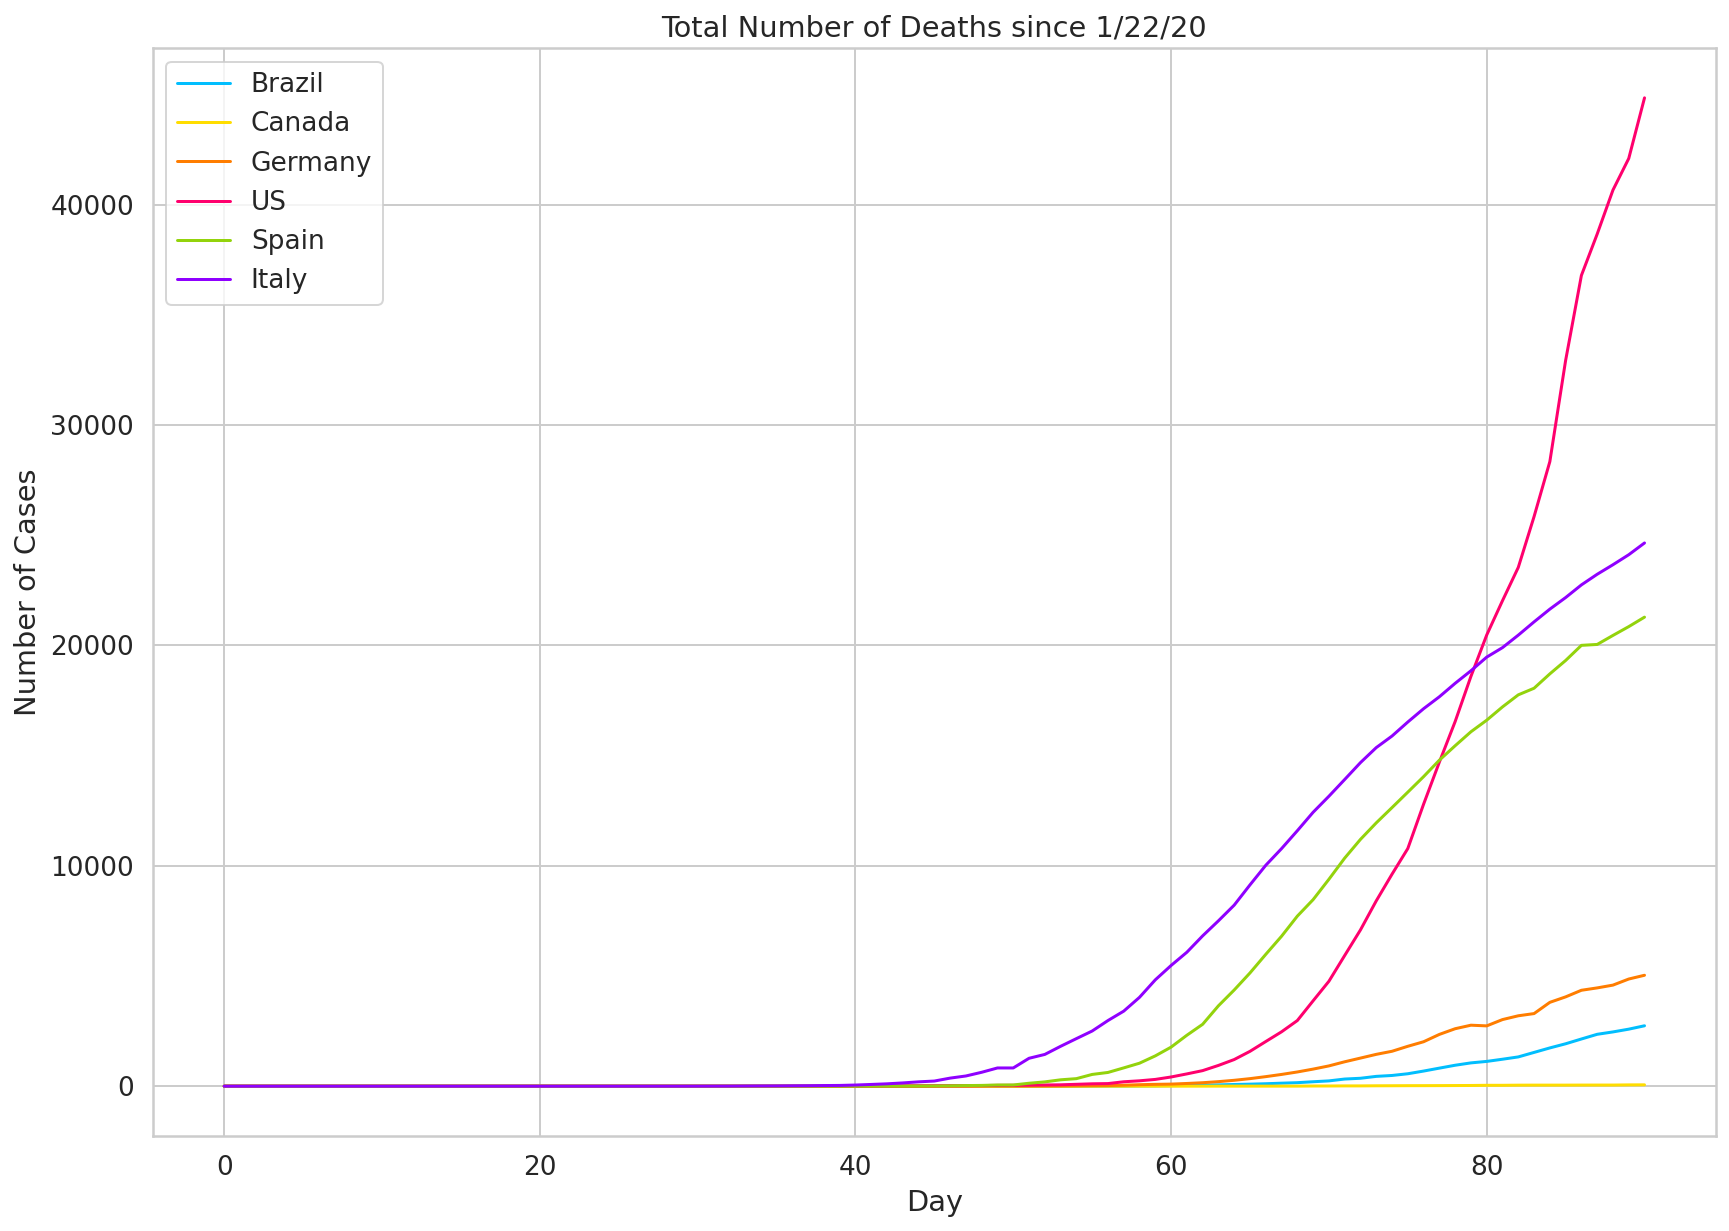

In [9]:
countries=['Brazil', 'Canada', 'Germany','US','Spain','Italy']
y=deaths.loc[deaths['Country/Region']=='Italy'].iloc[0,4:]
s = pd.DataFrame({'Italy':y})
for c in countries:    
    s[c] = deaths.loc[deaths['Country/Region']==c].iloc[0,4:]
    plt.plot(range(y.shape[0]),s[c],label=c)#    print(s[c])
plt.title('Total Number of Deaths since 1/22/20')
plt.xlabel('Day')
plt.ylabel('Number of Cases')
plt.legend(loc="best")
plt.show()

World wide growth of cases resulting in death


In [10]:
import matplotlib.pyplot as plt
country_list=deaths['Country/Region'].unique()
confirmed = pd.DataFrame({'Italy':y})
dict={}
a=[]
b=[]
#z=y.shape[0]

for c in country_list:
  #  print(c)
    a.append(c)
   # print(a)
    confirmed=( deaths.loc[deaths['Country/Region']==c].iloc[:,4:].sum(axis=0))
    b.append(confirmed[y.shape[0]-1])  
    dict[c]=confirmed[y.shape[0]-1]
#    print (confirmed[c][84])
dict
f = plt.figure(figsize=(90,40))
f.add_subplot(111)

barWidth=1
plt.axes(axisbelow=True)

plt.bar(a,b,linewidth=17.0)

plt.xlabel("Countries ",fontsize=45)
plt.ylabel("Number of deaths ",fontsize=45)
plt.title("Number of deaths around the world",fontsize=60)
plt.grid(alpha=0.3)
plt.tick_params(size=5,labelsize = 30,rotation=90)
plt.show()

Deaths in Canada

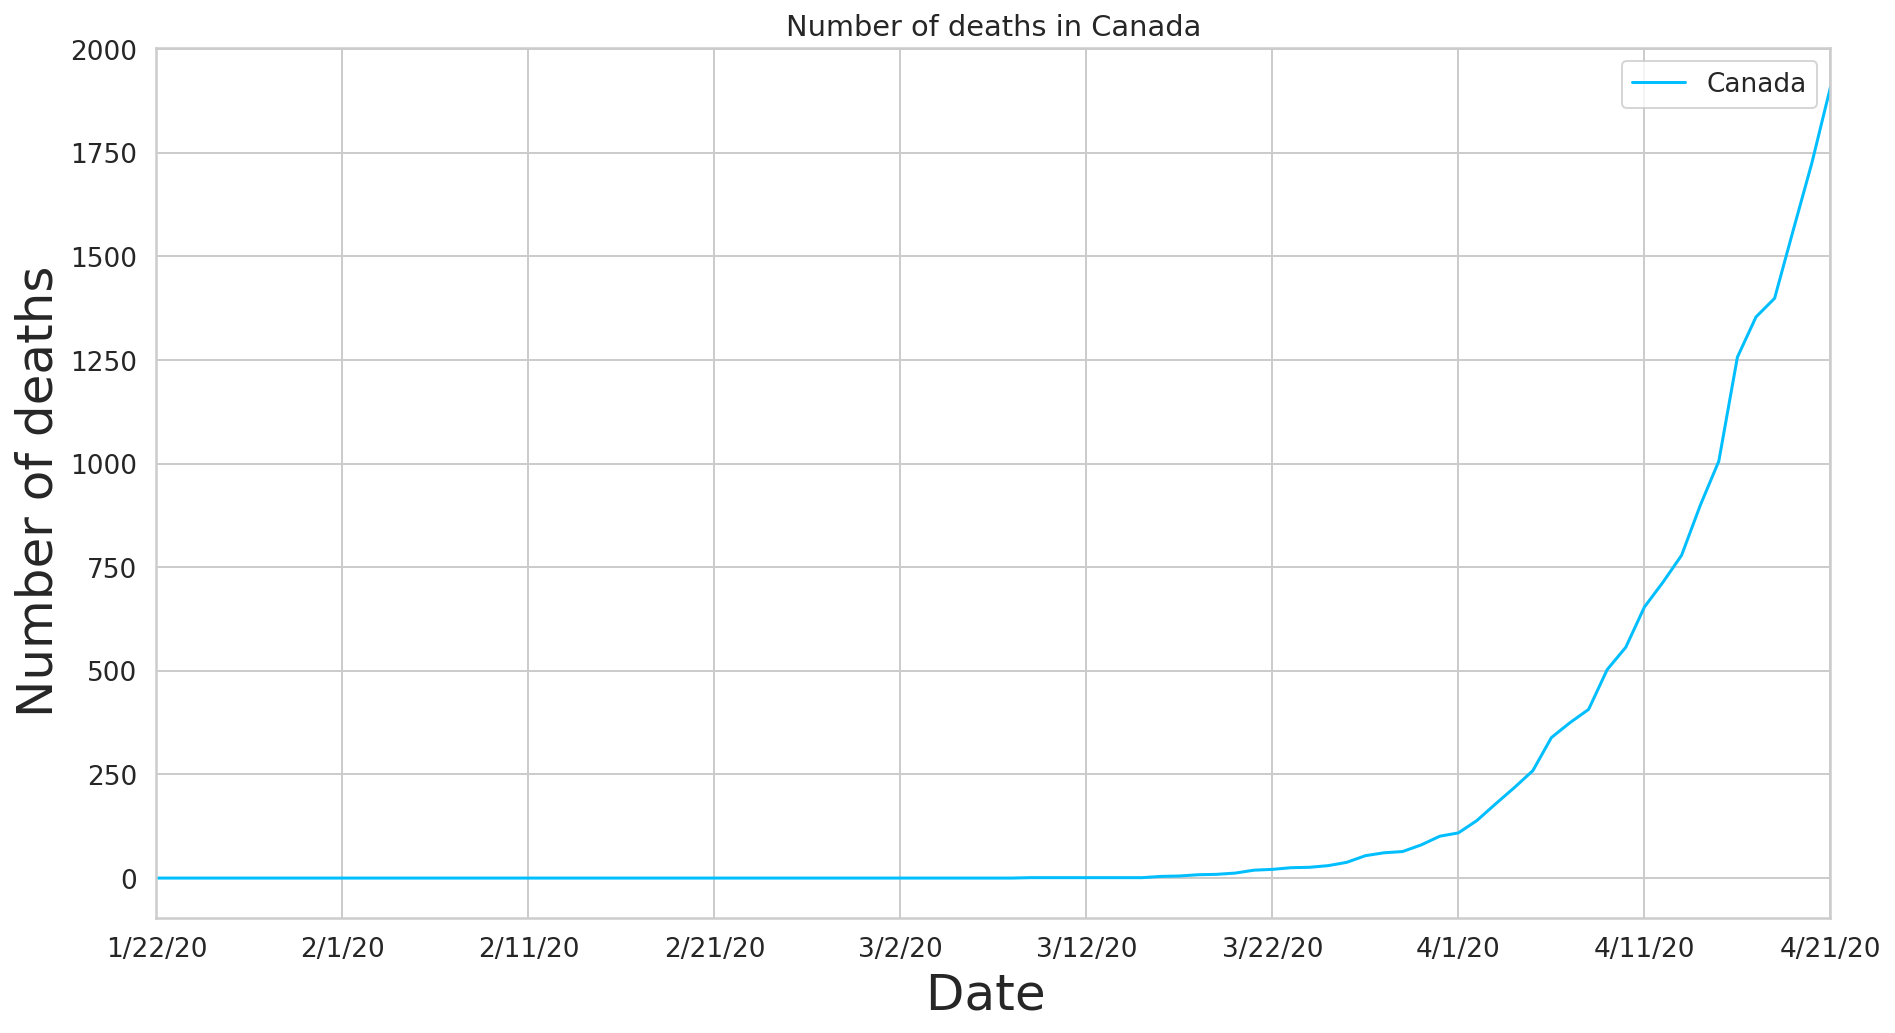

In [11]:
plt.figure(figsize=(15, 8))
canada = deaths.loc[deaths['Country/Region']=='Canada'].iloc[:,4:].sum(axis=0)
canada.tail()
canada.plot(label='Canada')
plt.legend()
plt.xlabel("Date ",fontsize=25)
plt.ylabel("Number of deaths ",fontsize=25)
plt.title("Number of deaths in Canada")
plt.show()

Moving Average


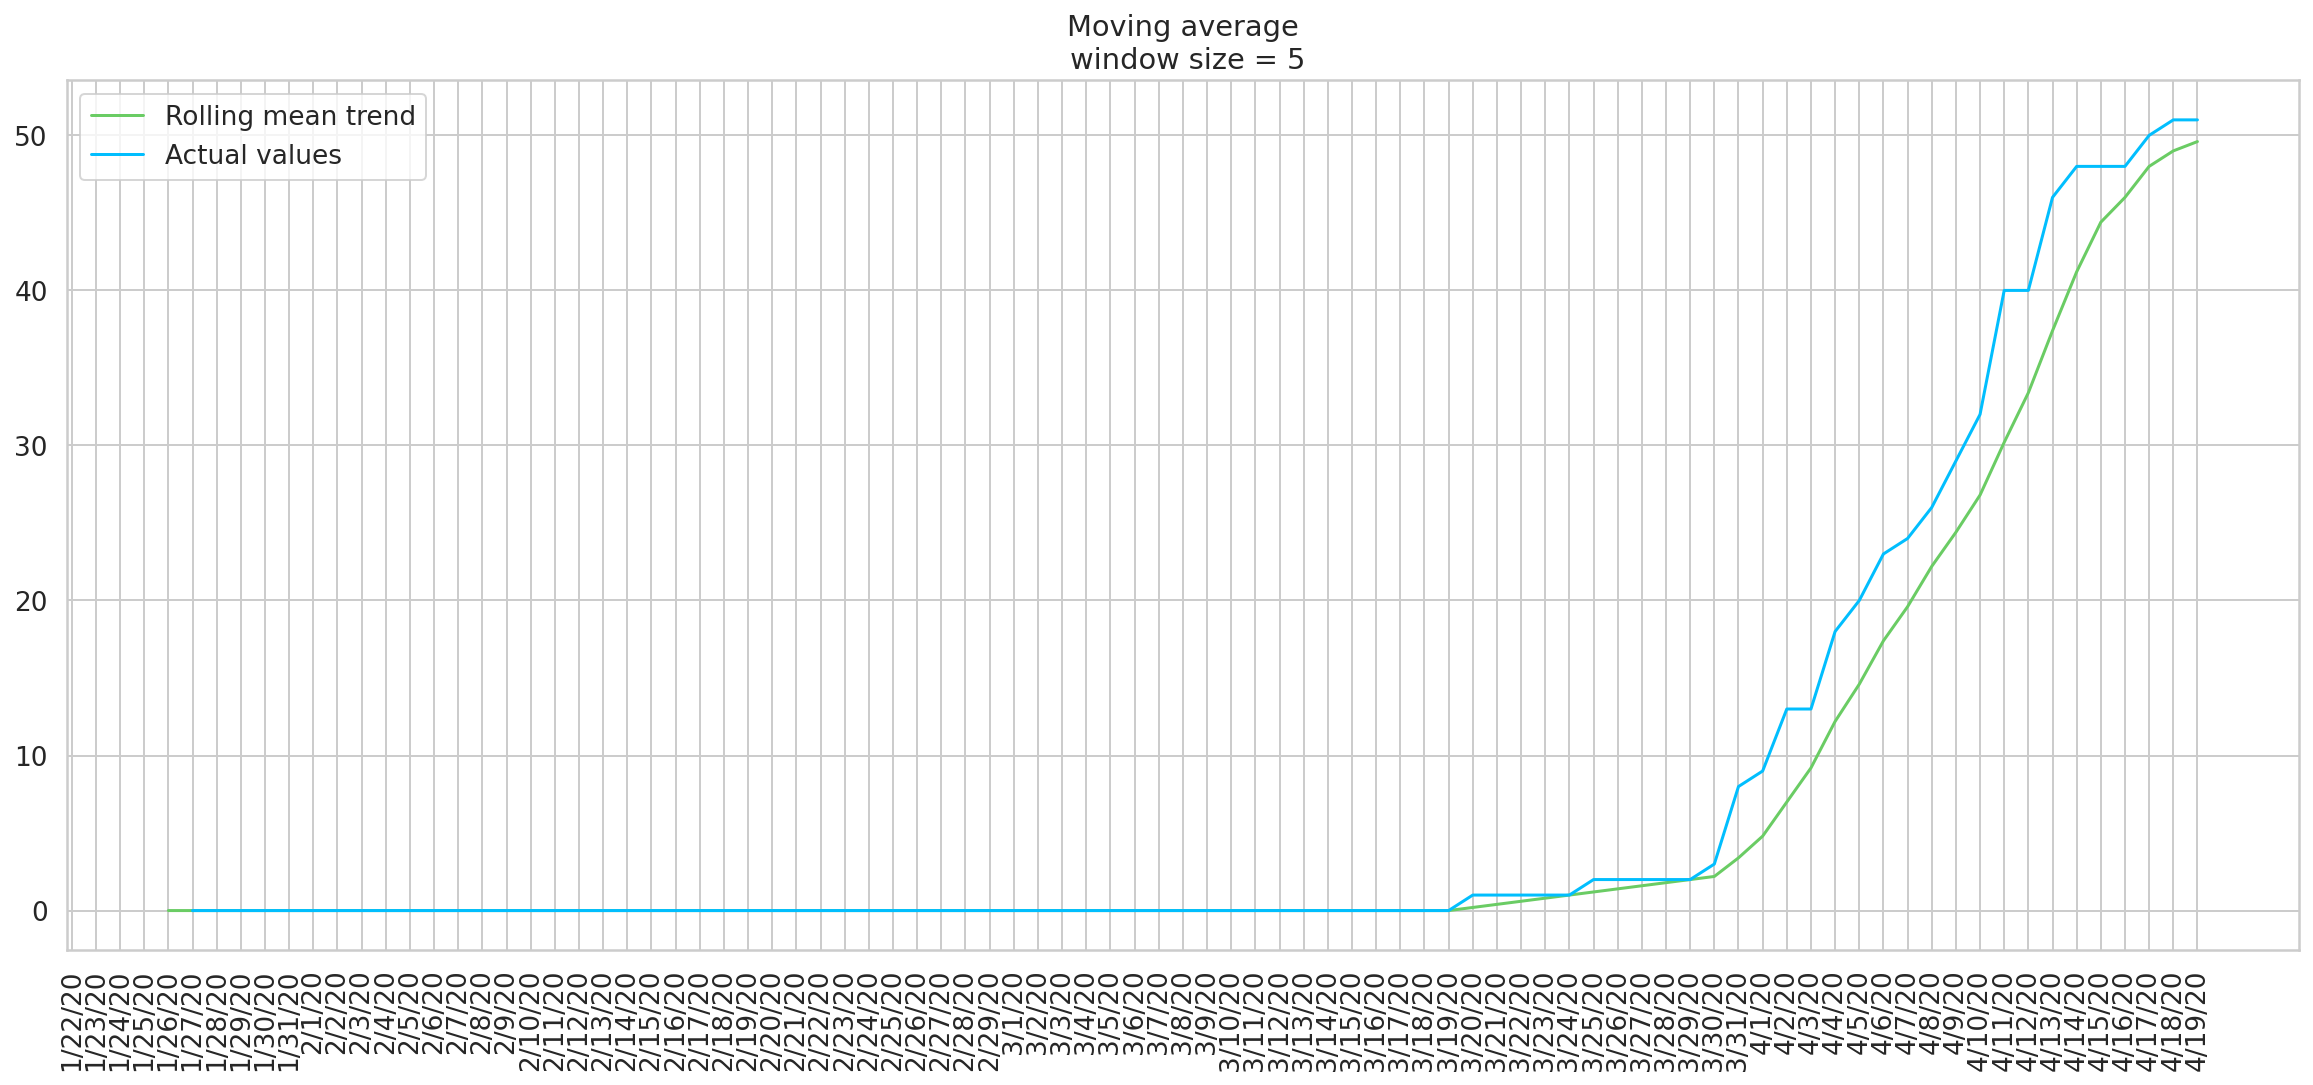

In [12]:
CAN = deaths[deaths['Country/Region']=='Canada']

CAN = pd.DataFrame(CAN.iloc[0,4:-2])

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(20,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(CAN, 5)

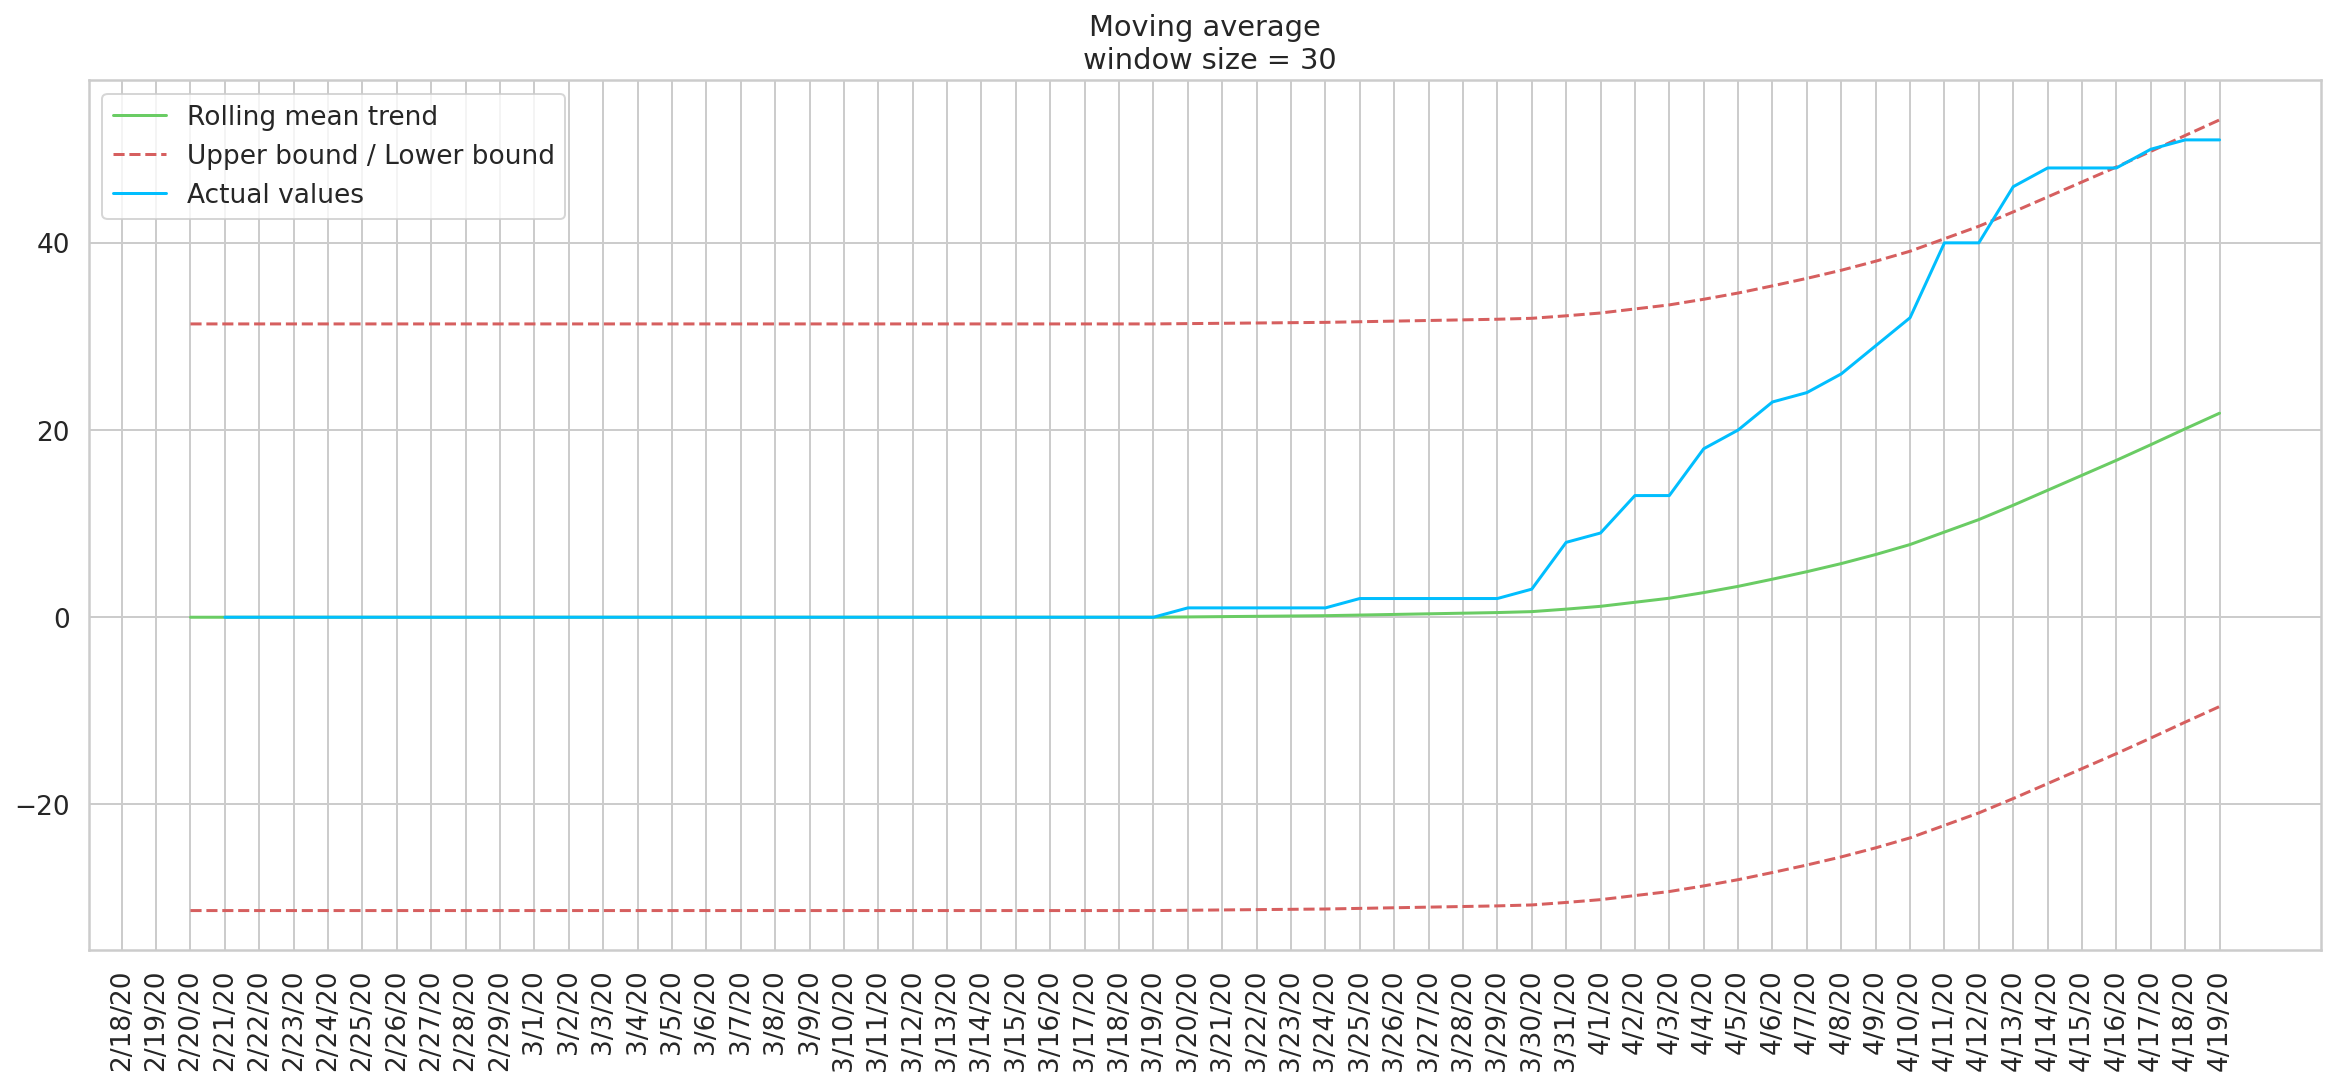

In [13]:
plot_moving_average(CAN, 30, plot_intervals=True)

In [14]:
dates=deaths.columns.values.tolist()
dates=dates[4:]

**ANALYSIS AND TRAINING OF DATA**

In [15]:
d=[]
for i in dates:
  d= deaths.iloc[:,4:].sum(axis=0)

In [16]:
d

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
4/17/20    153835
4/18/20    159509
4/19/20    165043
4/20/20    169985
4/21/20    176983
Length: 91, dtype: int64

In [17]:
X = np.array([i for i in range(len(dates))]).reshape(-1, 1)
Y = np.array(d).reshape(-1, 1)

Future forcasting

In [18]:
days_in_future = 15 #next 2 weeks
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-15]
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
    

In [19]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, Y, test_size=0.10, shuffle=False)

Model for predicting outcome as death

1. Support vector machines

In [20]:
# svm_confirmed = svm_search.best_estimator_


svm_confirmed2 = SVR(C=1,degree=5,kernel='poly',epsilon=0.01)
svm_confirmed2.fit(X_train_d, y_train_d)
svm_pred2 = svm_confirmed2.predict(future_forcast)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 6552.0617515221475
MSE: 52189096.20965421


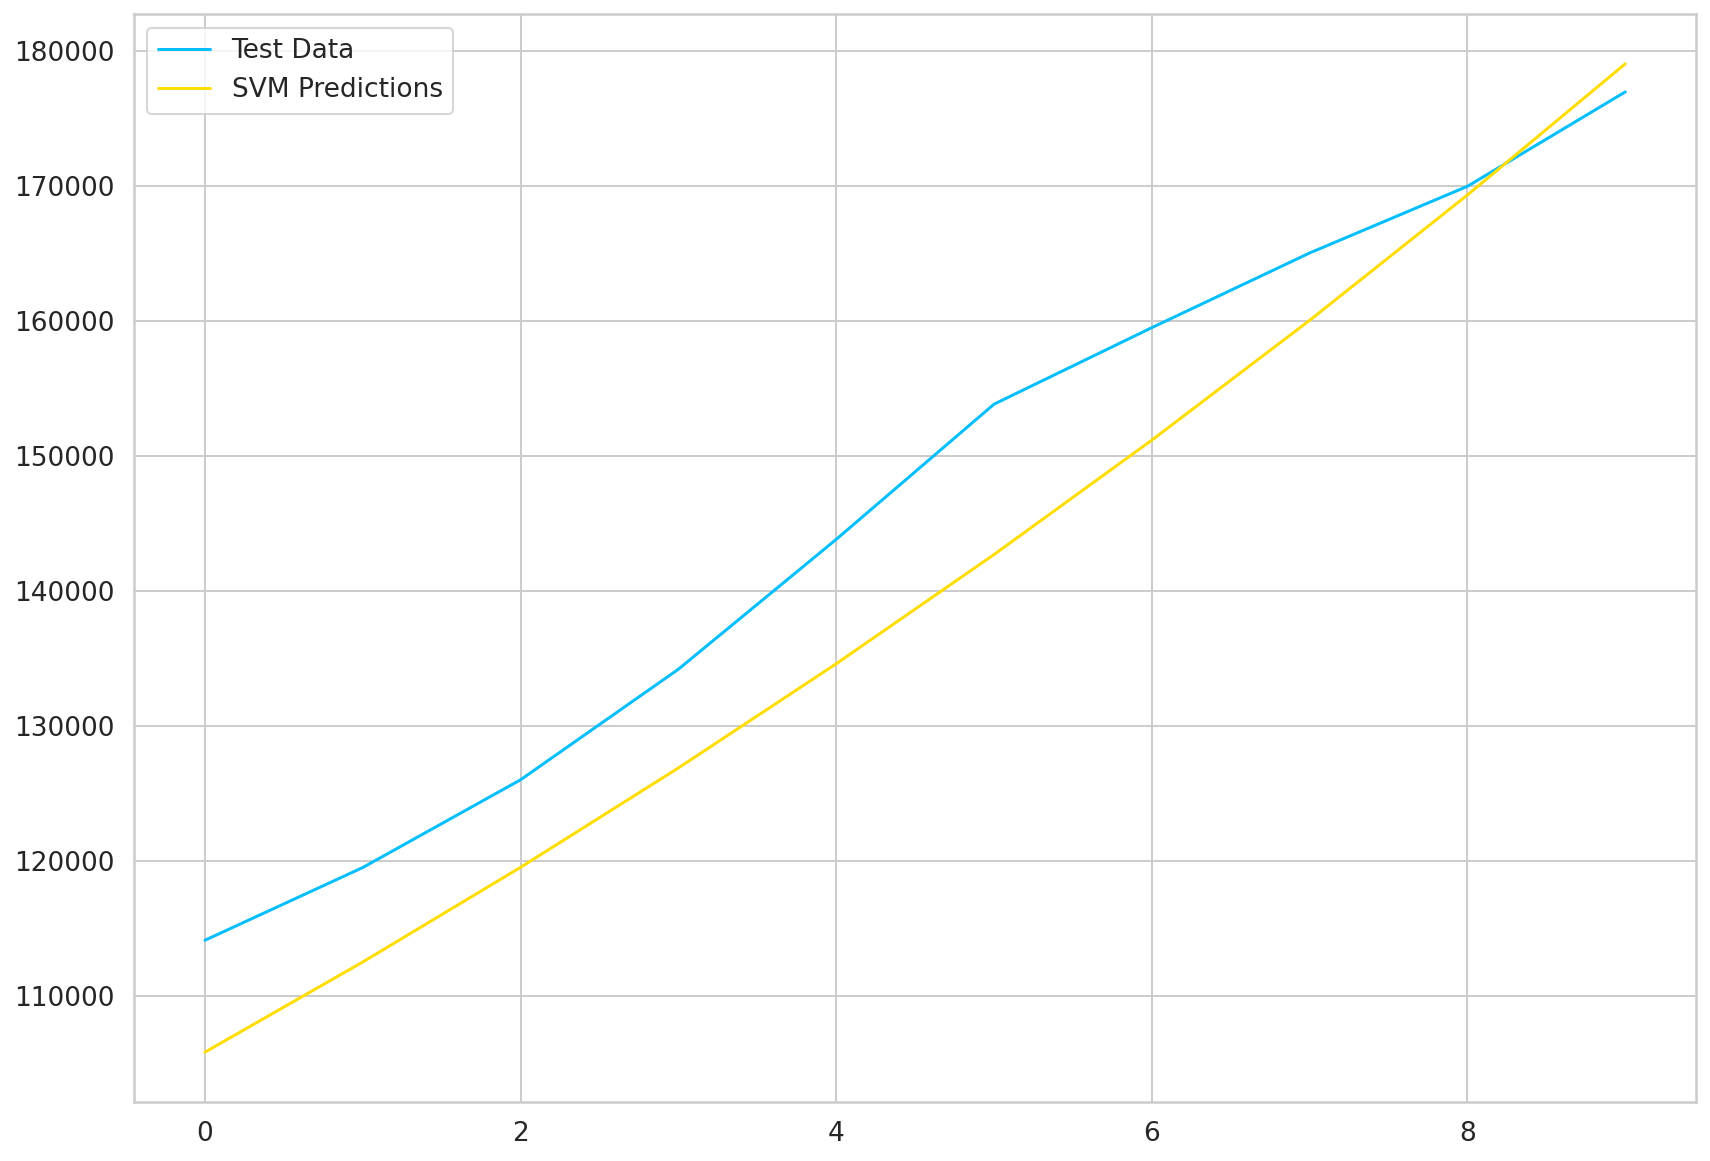

In [21]:
svm_test_pred2 = svm_confirmed2.predict(X_test_d)
plt.plot(y_test_d)
plt.plot(svm_test_pred2)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred2, y_test_d))
print('MSE:',mean_squared_error(svm_test_pred2, y_test_d))

Transforming our data for polynomial regression

In [22]:

poly = PolynomialFeatures(degree=3)
poly_X_train_d = poly.fit_transform(X_train_d)
poly_X_test_d = poly.fit_transform(X_test_d)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_d = bayesian_poly.fit_transform(X_train_d)
bayesian_poly_X_test_d = bayesian_poly.fit_transform(X_test_d)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)



2.   Linear regression



In [23]:
linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(poly_X_train_d, y_train_d)
test_linear_pred = linear_model.predict(poly_X_test_d)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_d))
print('MSE:',mean_squared_error(test_linear_pred, y_test_d))

MAE: 3298.5734964941453
MSE: 14572966.816442456


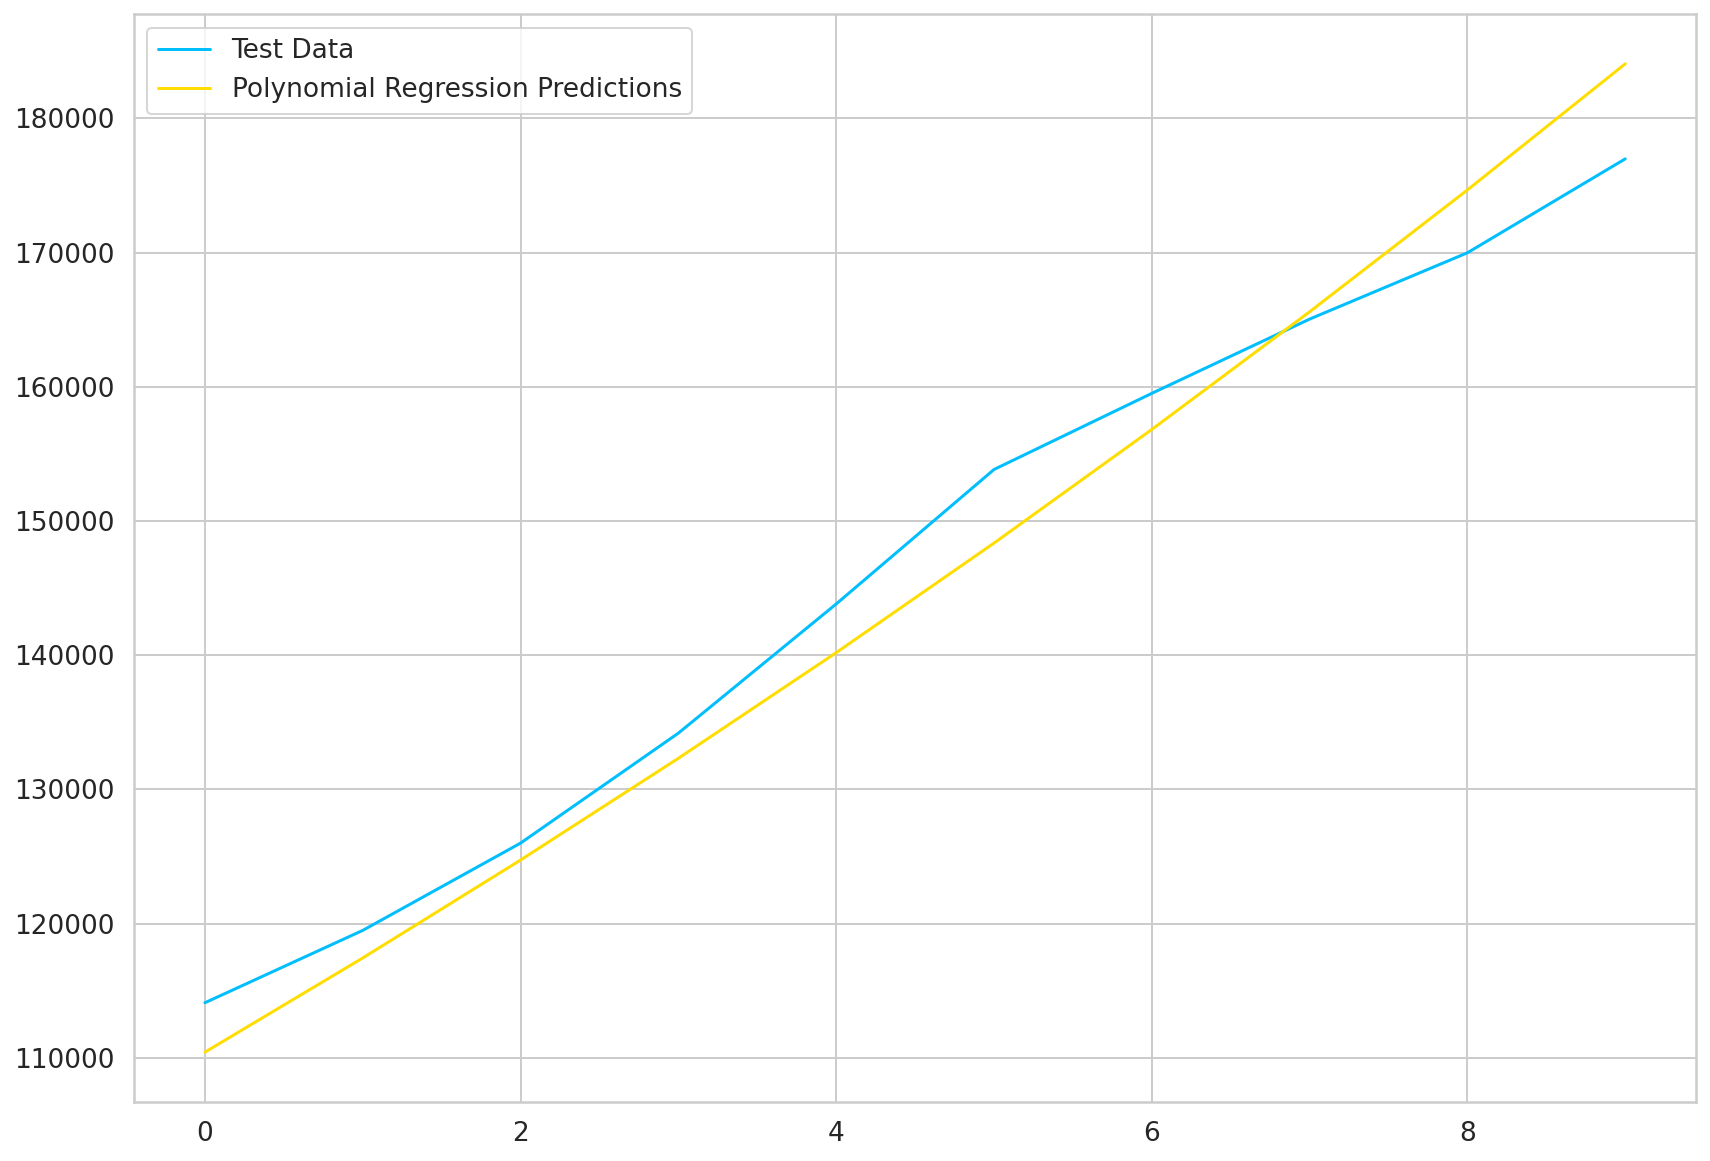

In [24]:
plt.plot(y_test_d)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])



3.   Bayesian ridge polynomial regression



In [25]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian2 = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search2 = RandomizedSearchCV(bayesian2, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search2.fit(bayesian_poly_X_train_d, y_train_d)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.4s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [26]:
bayesian_d = bayesian_search2.best_estimator_
test_bayesian_pred = bayesian_d.predict(bayesian_poly_X_test_d)
bayesian_pred = bayesian_d.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_d))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_d))

MAE: 3847.481997745531
MSE: 34719851.83630408


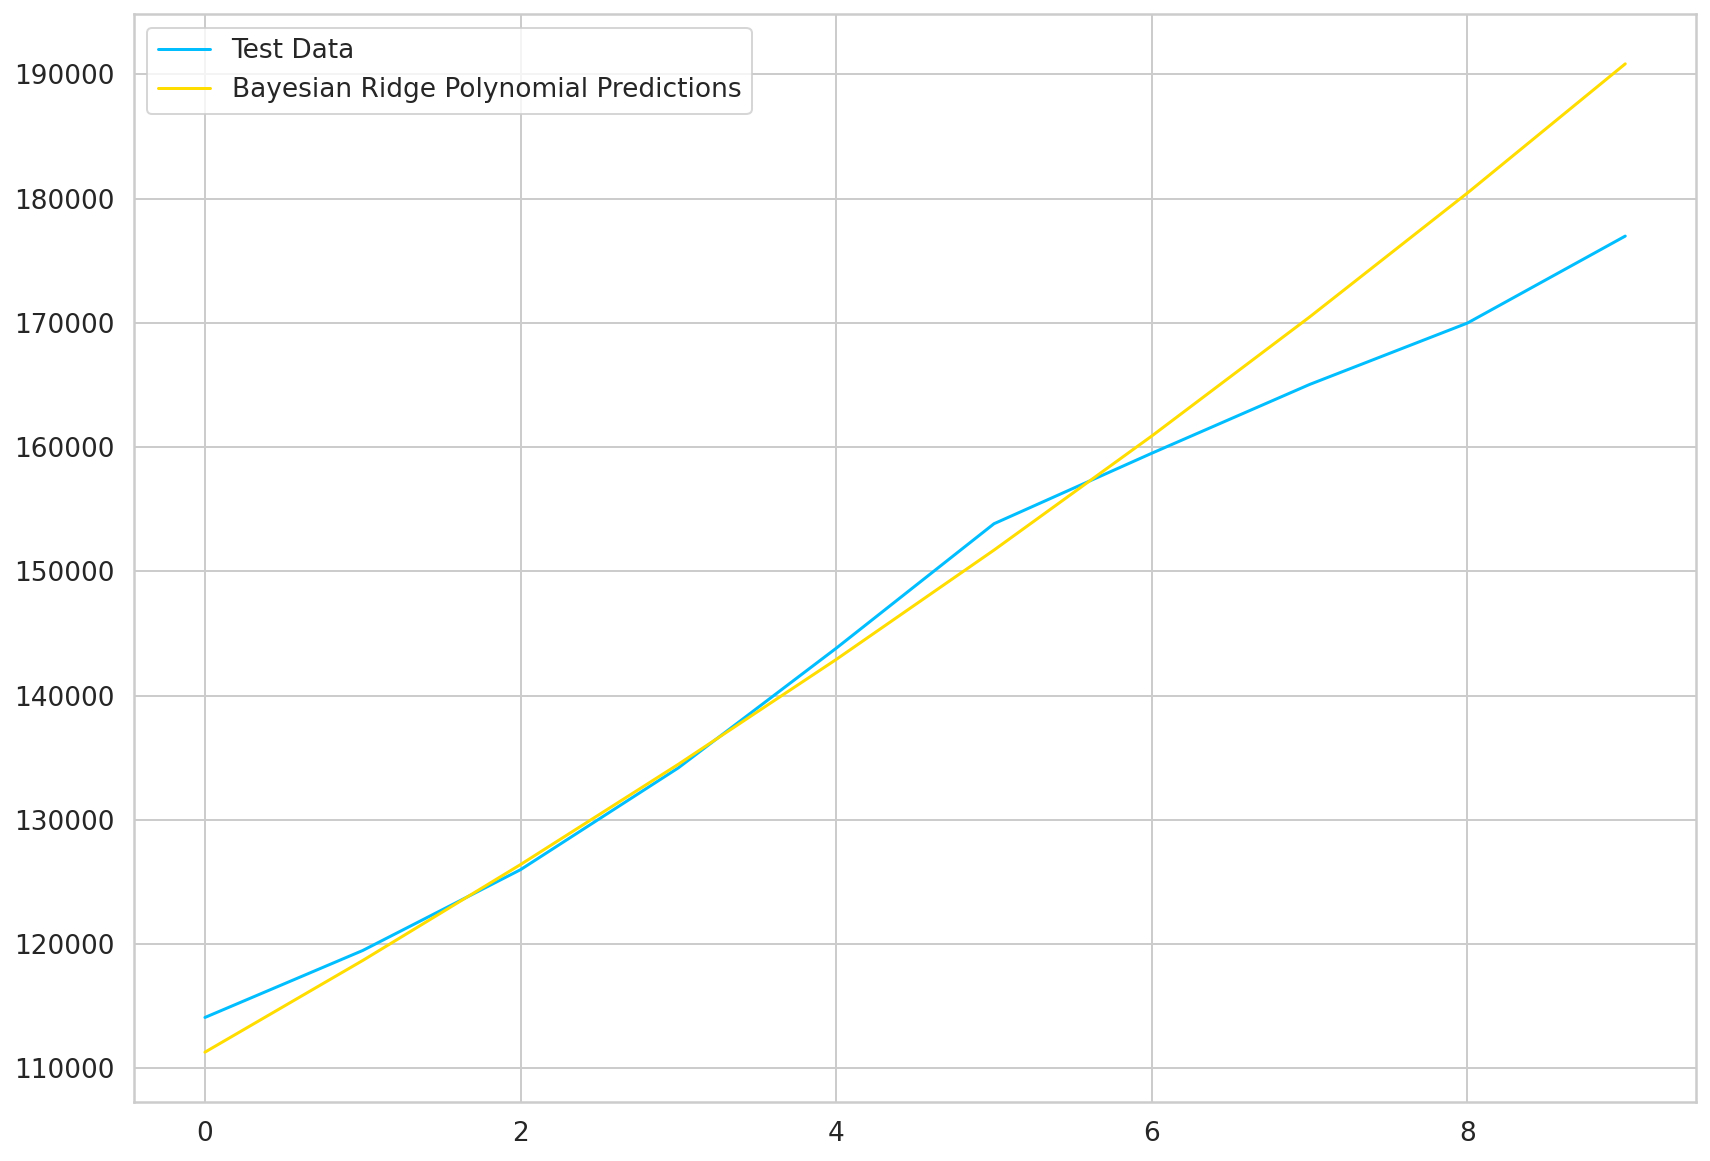

In [27]:
plt.plot(y_test_d)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

Predictions

In [30]:
def plot_predictions_death(x, y, pred, algo_name, color):
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title(' Deaths caused by Coronavirus Over Time', size=15)
    plt.xlabel('Days Since 1/22/2020', size=15)
    plt.ylabel('# of Cases', size=15)
    plt.legend(['Cases of death', algo_name], prop={'size': 15})
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show()

Prediction via SVM

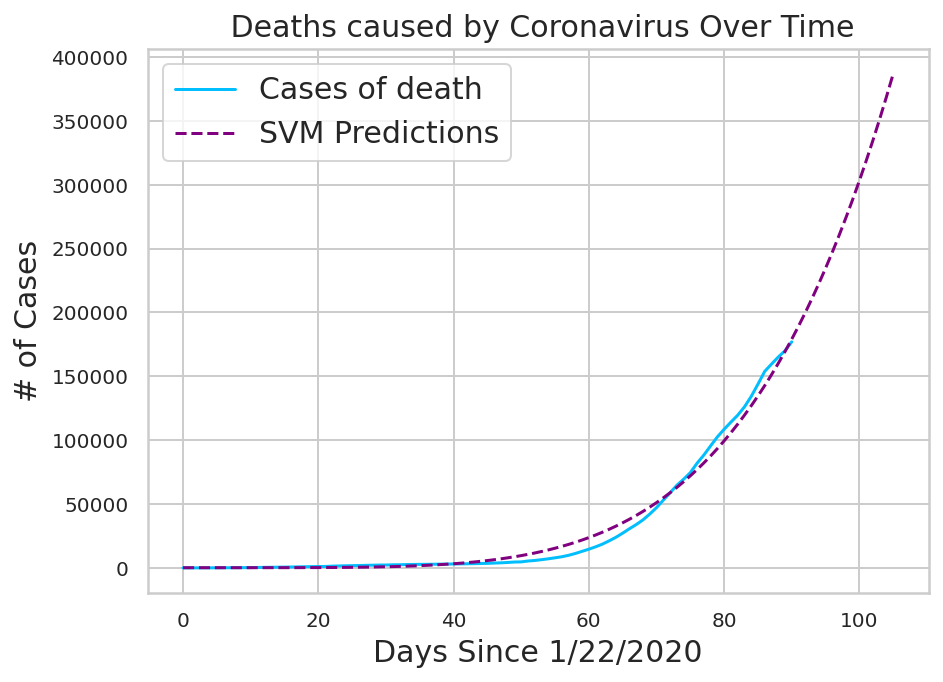

In [31]:
plot_predictions_death(adjusted_dates, d, svm_pred2, 'SVM Predictions', 'purple')

Prediction via Polynomial Regression

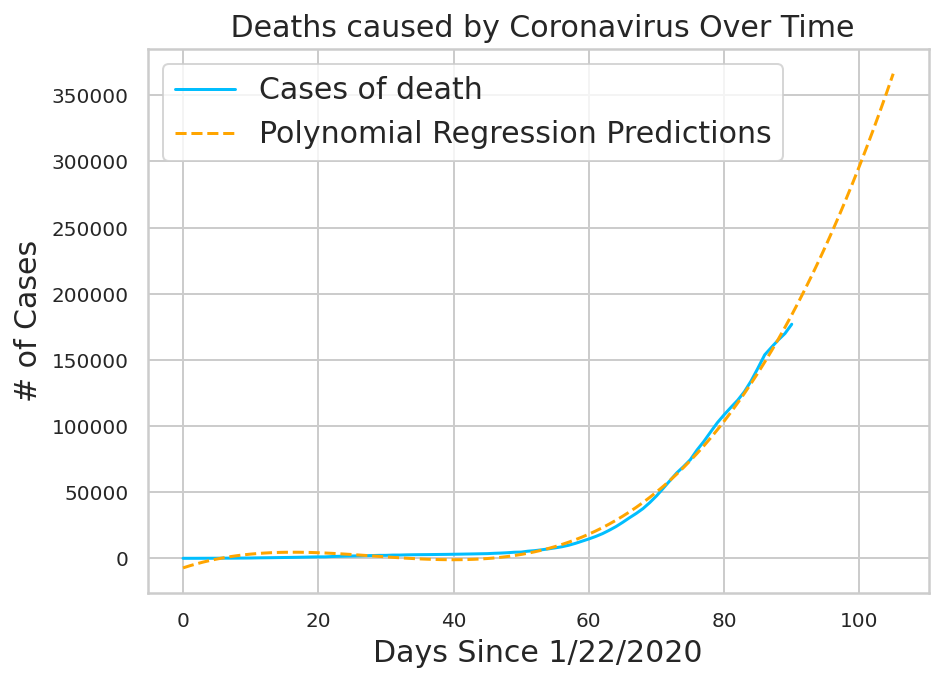

In [32]:
plot_predictions_death(adjusted_dates, d, linear_pred, 'Polynomial Regression Predictions', 'orange')

Prediction via Bayesian Ridge Regression

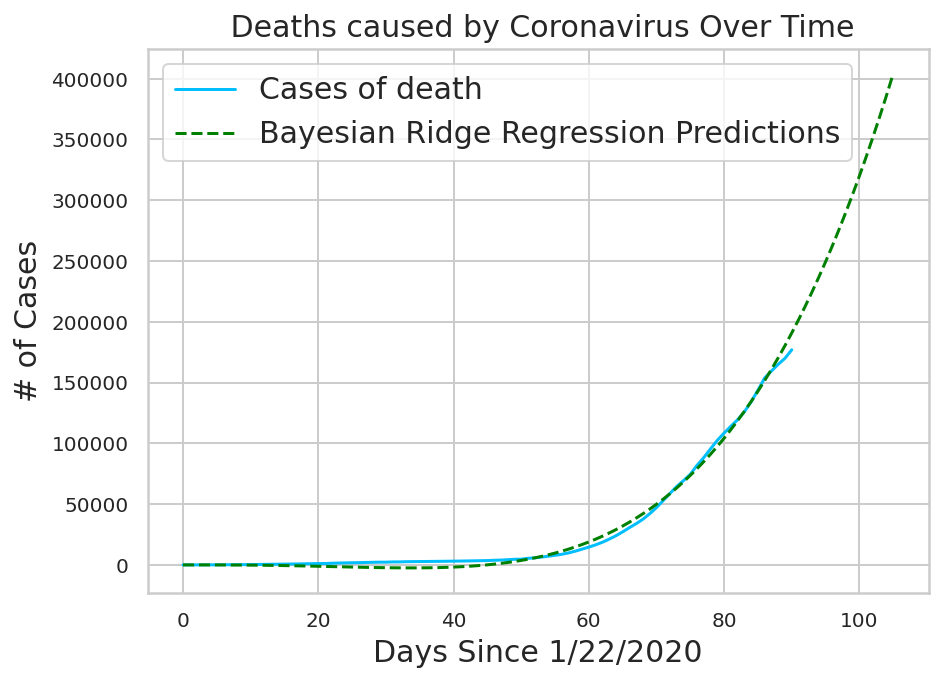

In [33]:
plot_predictions_death(adjusted_dates, d, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

Future predictions using SVM

In [34]:
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted Deaths Worldwide': np.round(svm_pred2[-10:])})
svm_df

,Date,SVM Predicted Deaths Worldwide
0,04/27/2020,247194.0
1,04/28/2020,260331.0
2,04/29/2020,274021.0
3,04/30/2020,288281.0
4,05/01/2020,303129.0
5,05/02/2020,318583.0
6,05/03/2020,334661.0
7,05/04/2020,351382.0
8,05/05/2020,368765.0
9,05/06/2020,386830.0


Future predictions using polynomial regression

In [35]:
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted Number of Deaths Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted Number of Deaths Worldwide
0,04/27/2020,247345.0
1,04/28/2020,259092.0
2,04/29/2020,271195.0
3,04/30/2020,283660.0
4,05/01/2020,296491.0
5,05/02/2020,309695.0
6,05/03/2020,323276.0
7,05/04/2020,337240.0
8,05/05/2020,351591.0
9,05/06/2020,366335.0


Future predictions using Bayesian Ridge

In [36]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted Number of Deaths Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted Number of Deaths Worldwide
0,04/27/2020,262506.0
1,04/28/2020,276107.0
2,04/29/2020,290212.0
3,04/30/2020,304835.0
4,05/01/2020,319987.0
5,05/02/2020,335680.0
6,05/03/2020,351928.0
7,05/04/2020,368741.0
8,05/05/2020,386135.0
9,05/06/2020,404120.0


Using prophet for automate future forecasting and predictions

***Prophet***  
We use Prophet, a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It is also an open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

***Why Prophet?***  
Prophet is easy to customize and use, and to produce accurate forecasts which can be explained intuitively with supporting evidence such as forecast seasonality components. It allows the analyst to explain in an intuitive and convinving manner to higher management as to why the forecasts are as such, and the plausible underlying factors that contribute to its result. Furthermore, it is also open-source! :)

***References***


1.   https://facebook.github.io/prophet/
2.   https://facebook.github.io/prophet/docs/
3.    https://github.com/facebook/prophet

In [37]:
df2 = pd.DataFrame(columns=['ds','y'])
df2
df2['ds'] = pd.to_datetime(dates)
for  j in range(0,len(d)):
 # print(d[j])
  df2['y'][j]=pd.to_numeric(d[j])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
df2

,ds,y
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56
...,...,...
86,2020-04-17,153835
87,2020-04-18,159509
88,2020-04-19,165043
89,2020-04-20,169985


Forecasting Confirmed Cases Worldwide with Prophet (Baseline)  
We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed

In [39]:
from fbprophet import Prophet
m = Prophet(interval_width=0.95)
m.fit(df2)
future = m.make_future_dataframe(periods=7)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

,ds
93,2020-04-24
94,2020-04-25
95,2020-04-26
96,2020-04-27
97,2020-04-28


In [40]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
93,2020-04-24,196854.897388,194685.680957,198900.122703
94,2020-04-25,203258.804896,200591.036523,206146.003374
95,2020-04-26,209540.568353,206460.198946,212792.328875
96,2020-04-27,215808.653894,212111.275656,219606.846459
97,2020-04-28,222586.547107,217755.743611,227341.388790


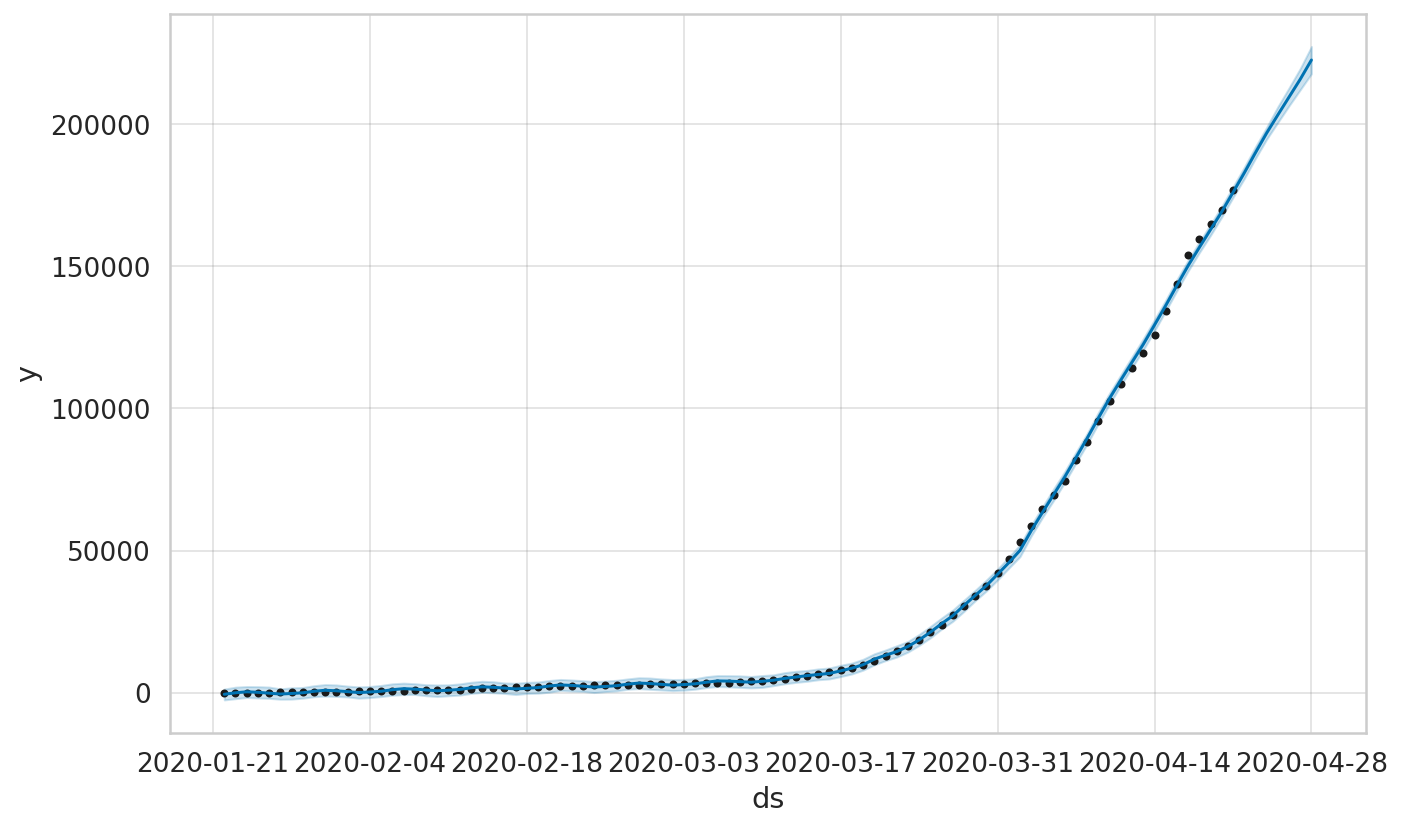

In [41]:
confirmed_forecast_plot = m.plot(forecast)

Logistic Curve Fitting We are going to use scipy.optimize.curve_fit to fit a logistic curve to the number of confirmed cases globally

In [43]:
confirmed_cases=get_covid_data(subset = 'CONFIRMED')# confirmed cases
confirmed_cases.loc[confirmed_cases['Country/Region']=='Canada']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
35,Alberta,Canada,53.9333,-116.5765,0,0,0,0,0,0,...,1567,1732,1870,1870,1996,2397,2562,2803,2908,3095
36,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,1445,1490,1490,1517,1561,1575,1618,1647,1647,1724
37,Grand Princess,Canada,37.6489,-122.6655,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
38,Manitoba,Canada,53.7609,-98.8139,0,0,0,0,0,0,...,242,246,246,246,250,250,253,254,254,255
39,New Brunswick,Canada,46.5653,-66.4619,0,0,0,0,0,0,...,114,116,116,117,117,117,117,118,118,118
40,Newfoundland and Labrador,Canada,53.1355,-57.6604,0,0,0,0,0,0,...,242,244,244,247,252,256,257,257,257,257
41,Nova Scotia,Canada,44.6820,-63.7443,0,0,0,0,0,0,...,445,474,517,549,579,606,649,675,721,737
42,Ontario,Canada,51.2538,-85.3232,0,0,0,0,1,1,...,7049,7470,7953,8447,9840,10456,11013,11561,12063,12715
43,Prince Edward Island,Canada,46.5107,-63.4168,0,0,0,0,0,0,...,25,25,25,26,26,26,26,26,26,26
44,Quebec,Canada,52.9399,-73.5491,0,0,0,0,0,0,...,12846,13557,14248,14860,15857,16798,17521,17950,19319,20126


In [44]:
c2=[]
for i in dates:
  c2= confirmed_cases.iloc[:,4:].sum(axis=0)
#  world_cases.append(c)
d2=[]
for i in dates:
  d2= deaths.iloc[:,4:].sum(axis=0)
d

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
4/17/20    153835
4/18/20    159509
4/19/20    165043
4/20/20    169985
4/21/20    176983
Length: 91, dtype: int64

In [45]:
from scipy.optimize import curve_fit
details = pd.DataFrame(columns=['ds','Confirmed','Deaths'])

details['ds'] = pd.to_datetime(dates)
for  j in range(0,len(d)):
 # print(d[j])
  details['Confirmed'][j]=pd.to_numeric(c2[j])
  details['Deaths'][j]=pd.to_numeric(d2[j])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
x_data = range(len(details.index))
y_data = details['Confirmed']

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

# Fit the curve
popt, pcov = curve_fit(log_curve, x_data, y_data)#, bounds=([0,0,0],np.inf), maxfev=50000)
estimated_k, estimated_x_0, ymax= popt


# Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0
y_fitted = log_curve(range(0,160), k, x_0, ymax)
print(k, x_0, ymax)
#print(y_fitted)
y_data.tail()


0.10751512417335031 79.00925507226383 3308638.6083461926


86    2240190
87    2317758
88    2401378
89    2472258
90    2561043
Name: Confirmed, dtype: object

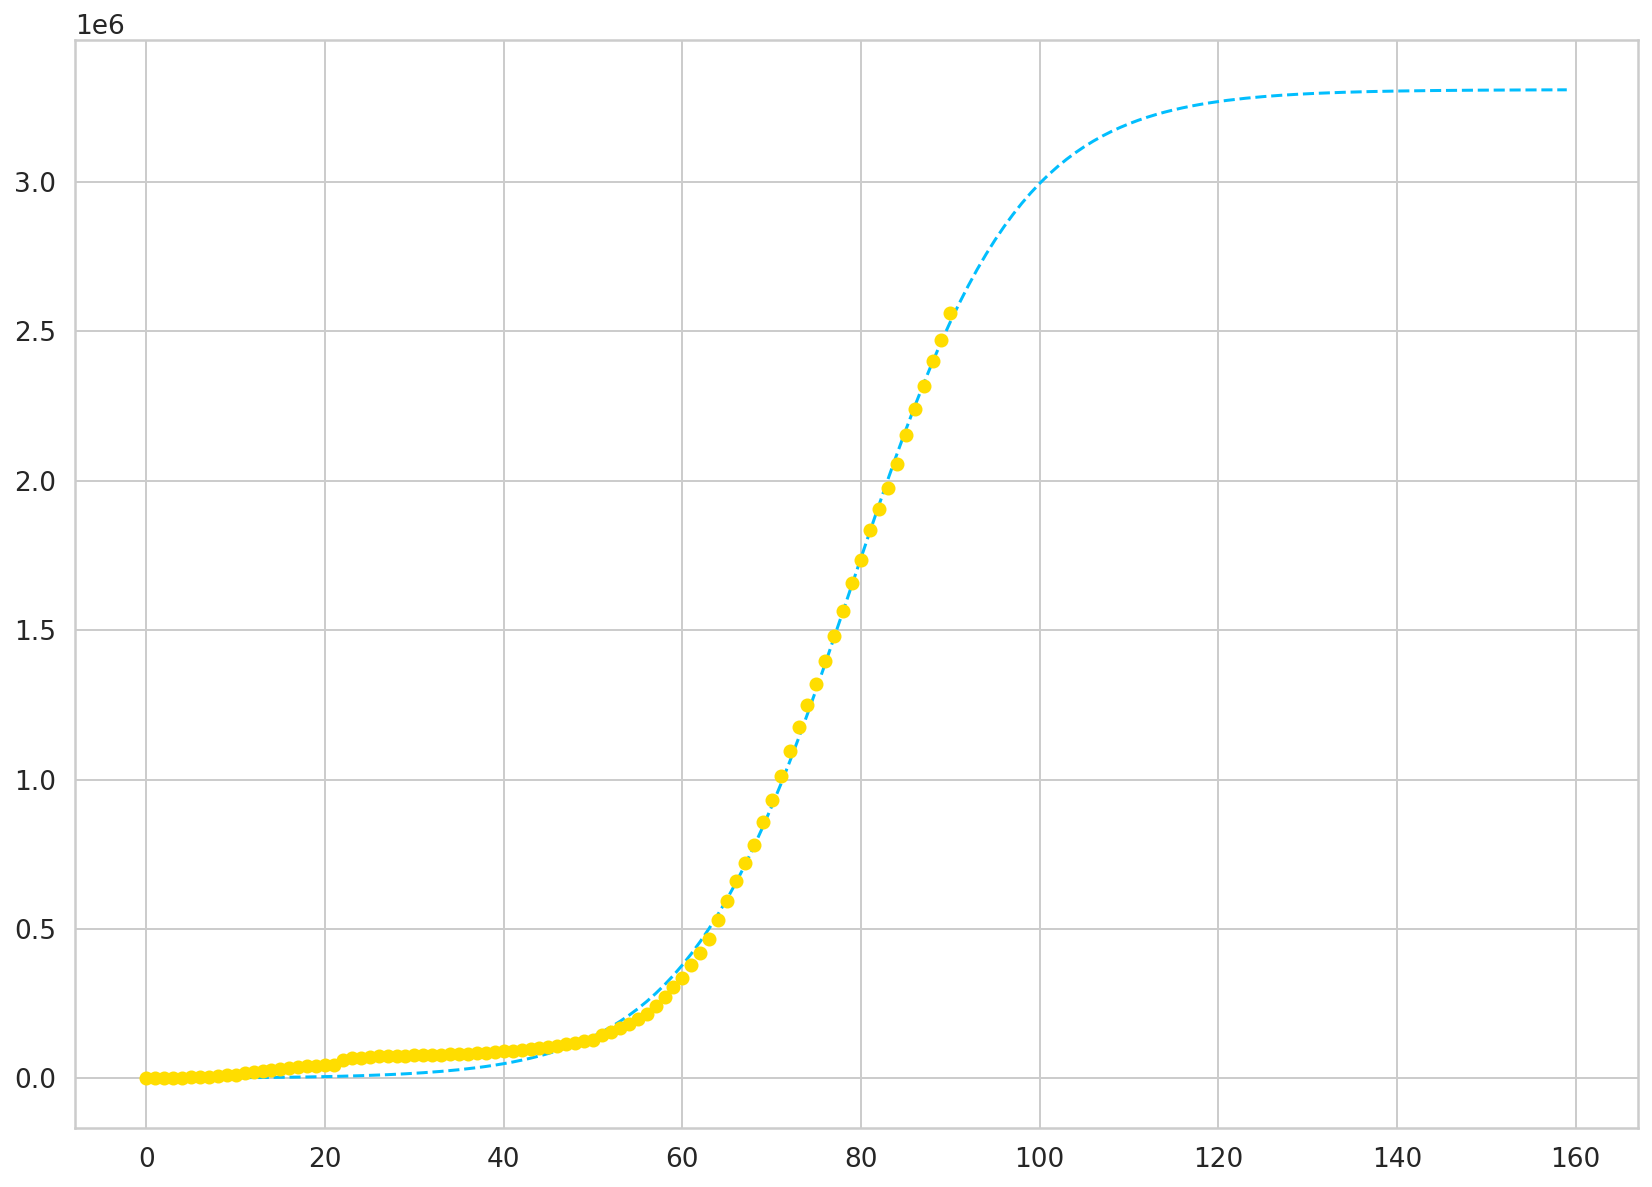

In [47]:
# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,160), y_fitted, '--', label='fitted')
ax.plot(x_data, y_data, 'o', label='Confirmed Data')

Notice that this predicts that globally the infection hit the highest between 60-80 days from it start and the number of confirmed cases will max out around 3 million cases. We should consider that there is a lot of statistical uncertainty in this prediction. This is almost certainly underestimating. Furthermore, for some countries, it is too early to use this method to get a reasonable estimate. We should also consider that the number of positive undiagnosed cases in each country is likely to be signigicant. This, along with the fact that most countries aren't testing enough, the mortality rate is likely inflated since the number of actual positive cases in each population is likely considerably higher than confirmed cases.

Death prediction using RNN

In [48]:
daily_deaths=d.copy()
daily_deaths.head()

1/22/20    17
1/23/20    18
1/24/20    26
1/25/20    42
1/26/20    56
dtype: int64

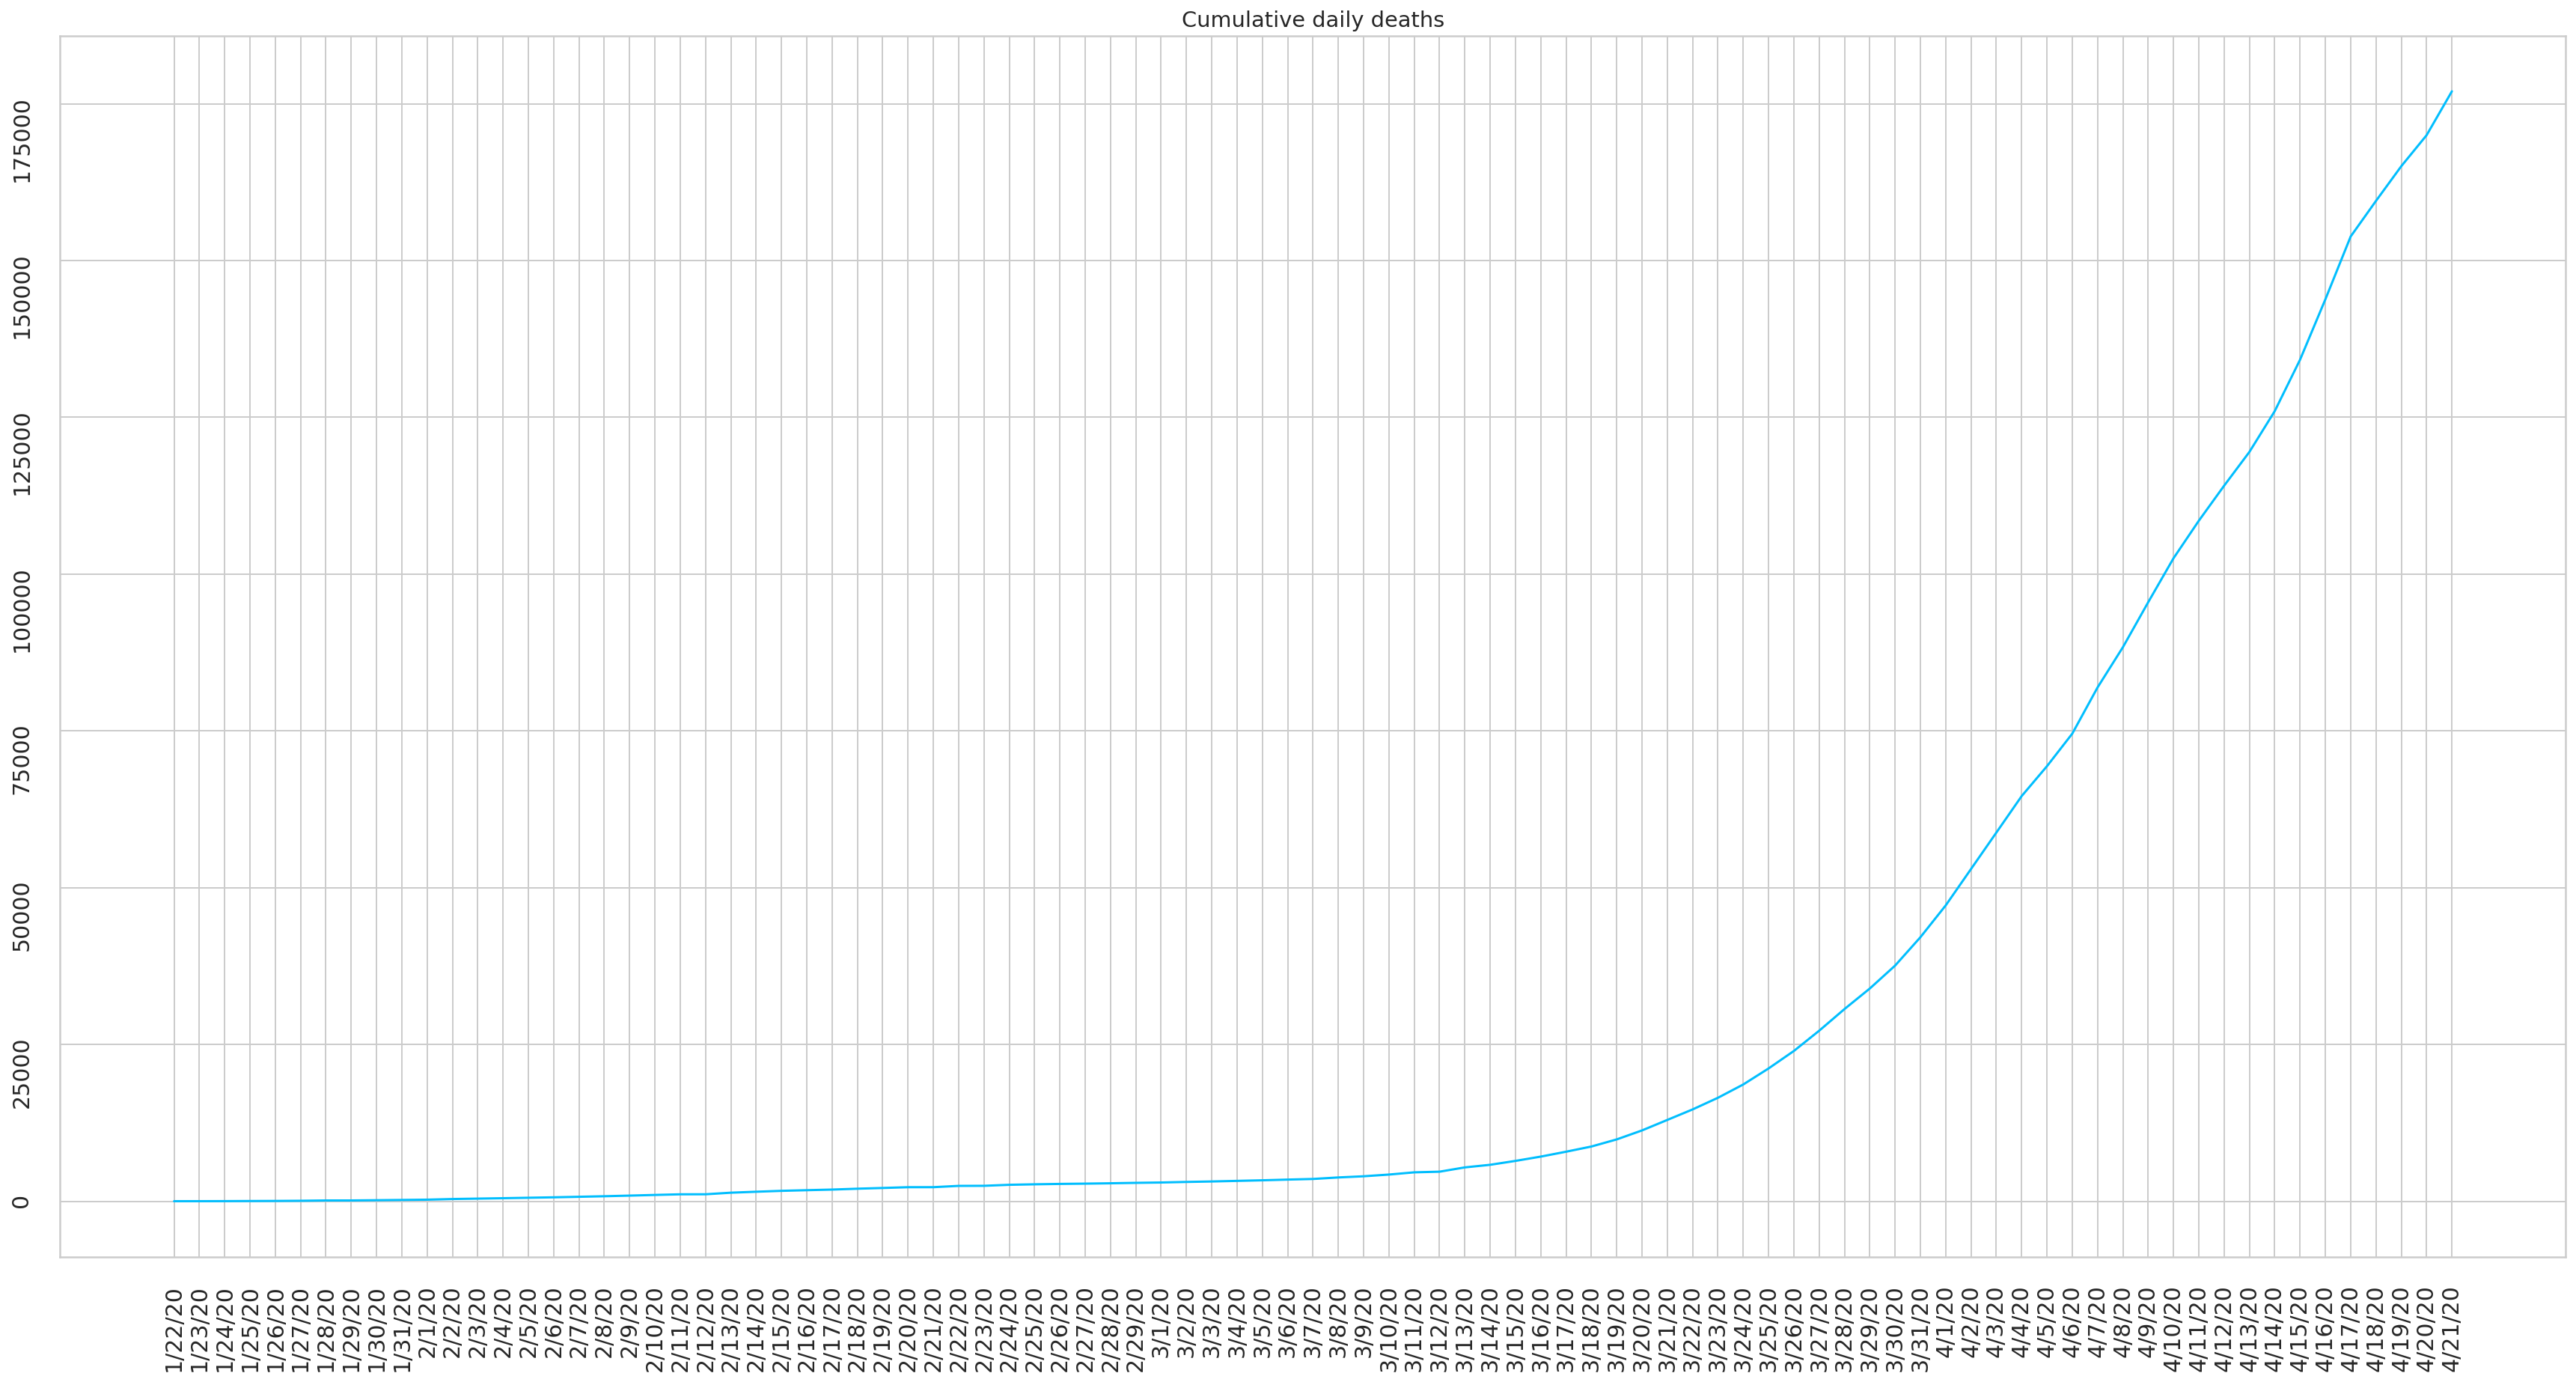

In [49]:
plt.figure(figsize=(30, 15))
plt.plot(daily_deaths)
plt.title("Cumulative daily deaths");
plt.tick_params(size=15,labelsize = 15,rotation=90)
plt.show()

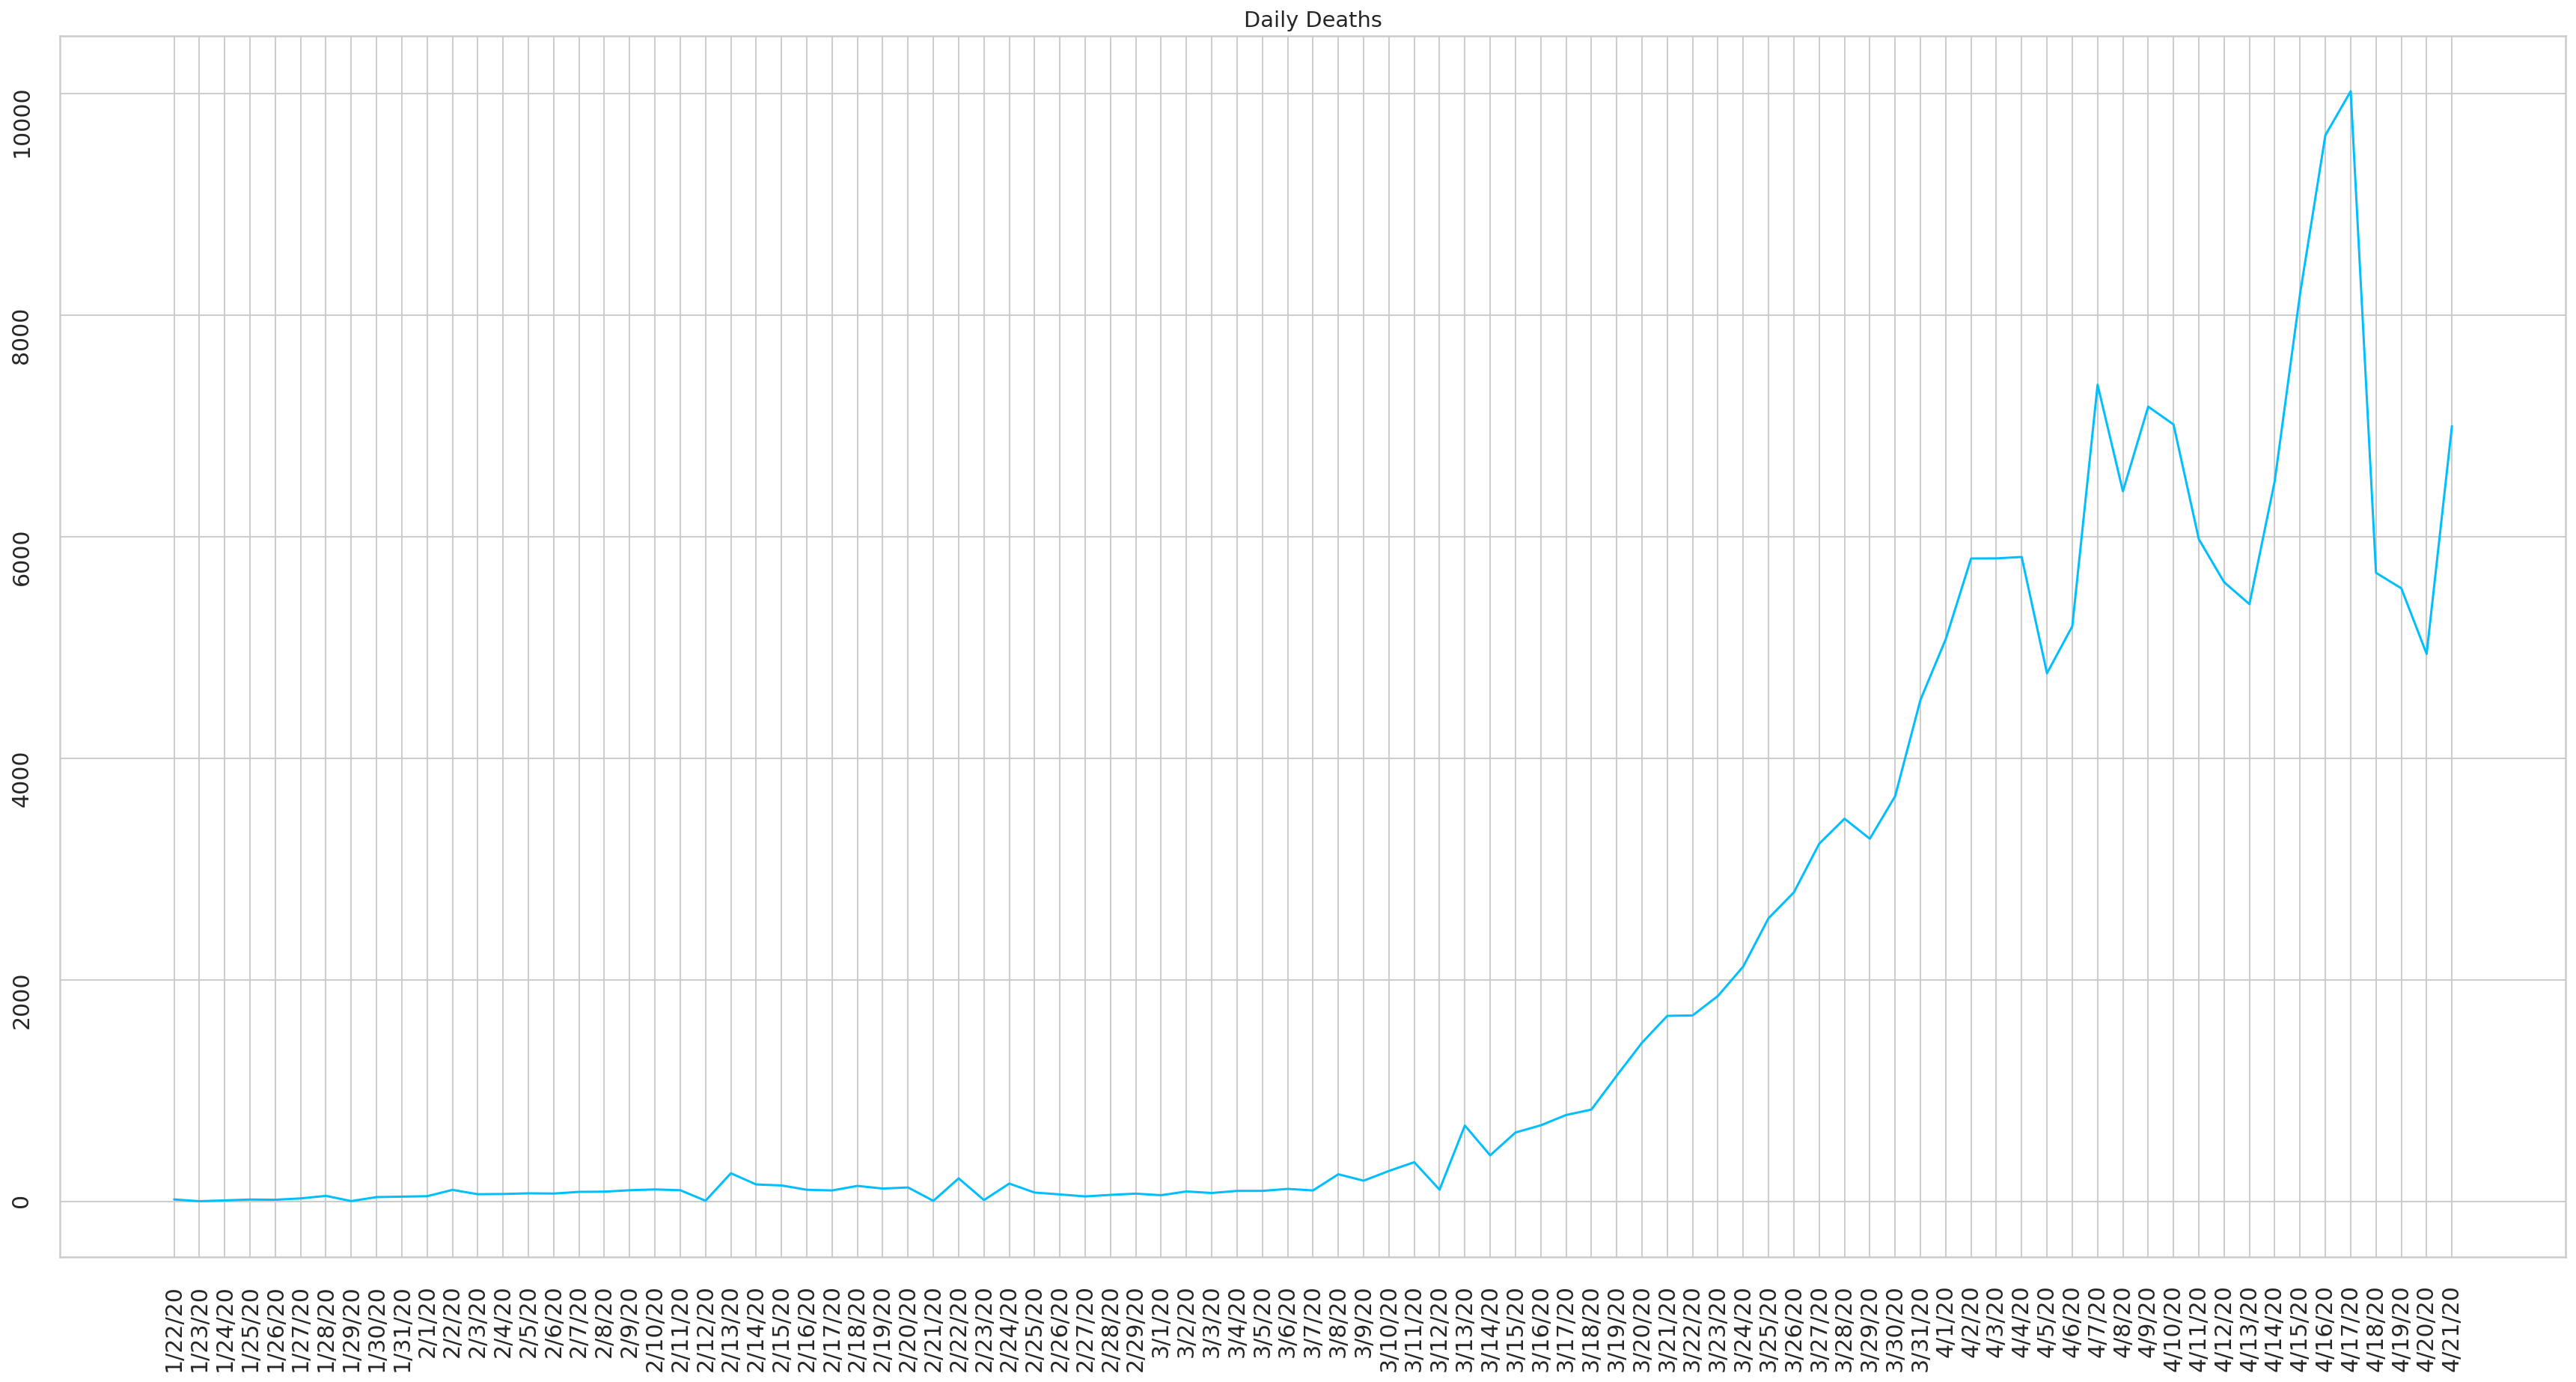

In [50]:
daily_deaths = daily_deaths.diff().fillna(daily_deaths[0]).astype(np.int64)
daily_deaths.head

plt.figure(figsize=(30, 15))

plt.plot(daily_deaths)
plt.title("Daily Deaths");

plt.tick_params(size=15,labelsize = 15,rotation=90)
plt.show()


Preprocessing

Testing on available data

In [51]:
test_data_size2 = 14

train_data2 = daily_deaths[:-test_data_size2]
test_data2 = daily_deaths[-test_data_size2:]

train_data2.shape

(77,)

In [52]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data2, axis=1))

train_data2 = scaler.transform(np.expand_dims(train_data2, axis=1))

test_data2 = scaler.transform(np.expand_dims(test_data2, axis=1))

Currently, we have a big sequence of daily cases. We’ll convert it into smaller ones

In [53]:
def create_sequences(data, seq_length):
    xs2 = []
    ys2 = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs2.append(x)
        ys2.append(y)

    return np.array(xs2), np.array(ys2)
seq_length = 5
X_train2, y_train2 = create_sequences(train_data2, seq_length)
X_test2, y_test2 = create_sequences(test_data2, seq_length)

X_train2 = torch.from_numpy(X_train2).float()
y_train2 = torch.from_numpy(y_train2).float()

X_test2 = torch.from_numpy(X_test2).float()
y_test2 = torch.from_numpy(y_test2).float()

Building a model

In [54]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )
    self.rnn = nn.RNN( input_size=n_features, hidden_size=n_hidden,  num_layers=n_layers, batch_first=True, nonlinearity='relu')
 

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Training

In [55]:
#deaths
def train_model(
  model,
  train_data2,
  train_labels2,
  test_data2=None,
  test_labels2=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 100

  train_hist2 = np.zeros(num_epochs)
  test_hist2 = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred2 = model(X_train2)

    loss2 = loss_fn(y_pred2.float(), y_train2)

    if test_data2 is not None:
      with torch.no_grad():
        y_test_pred2 = model(X_test2)
        test_loss2 = loss_fn(y_test_pred2.float(), y_test2)
      test_hist2[t] = test_loss2.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss2.item()} test loss: {test_loss2.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss2.item()}')

    train_hist2[t] = loss2.item()

    optimiser.zero_grad()

    loss2.backward()

    optimiser.step()

  return model.eval(), train_hist2, test_hist2




In [56]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=90, #
  seq_len=seq_length,
  n_layers=2
)

In [57]:
#deaths
model, train_hist2, test_hist2 = train_model(
  model,
  X_train2,
  y_train2,
  X_test2,
  y_test2
)



Epoch 0 train loss: 4.974205493927002 test loss: 7.580440521240234
Epoch 10 train loss: 3.649595022201538 test loss: 4.803880214691162
Epoch 20 train loss: 3.2194690704345703 test loss: 4.975200653076172
Epoch 30 train loss: 1.7959095239639282 test loss: 1.0121506452560425
Epoch 40 train loss: 1.2065331935882568 test loss: 14.340066909790039
Epoch 50 train loss: 1.0472348928451538 test loss: 8.70175838470459
Epoch 60 train loss: 1.219352126121521 test loss: 21.662565231323242
Epoch 70 train loss: 0.9890857934951782 test loss: 13.735064506530762
Epoch 80 train loss: 0.883026123046875 test loss: 13.298959732055664
Epoch 90 train loss: 0.9921625256538391 test loss: 14.997139930725098


Use all data for training

In [63]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_deaths, axis=1))

all_data = scaler.transform(np.expand_dims(daily_deaths, axis=1))

all_data.shape

(91, 1)

In [64]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=70,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist2, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 6.265720844268799
Epoch 10 train loss: 3.9009575843811035
Epoch 20 train loss: 3.433727264404297
Epoch 30 train loss: 3.145678997039795
Epoch 40 train loss: 2.2646591663360596
Epoch 50 train loss: 1.1514009237289429
Epoch 60 train loss: 0.9971867203712463
Epoch 70 train loss: 0.9823107123374939
Epoch 80 train loss: 1.015669822692871
Epoch 90 train loss: 0.9322038292884827


Predicting future cases


In [65]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred2 = model(test_seq)
    pred = torch.flatten(y_test_pred2).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
#As before, we’ll inverse the scaler transformation:

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

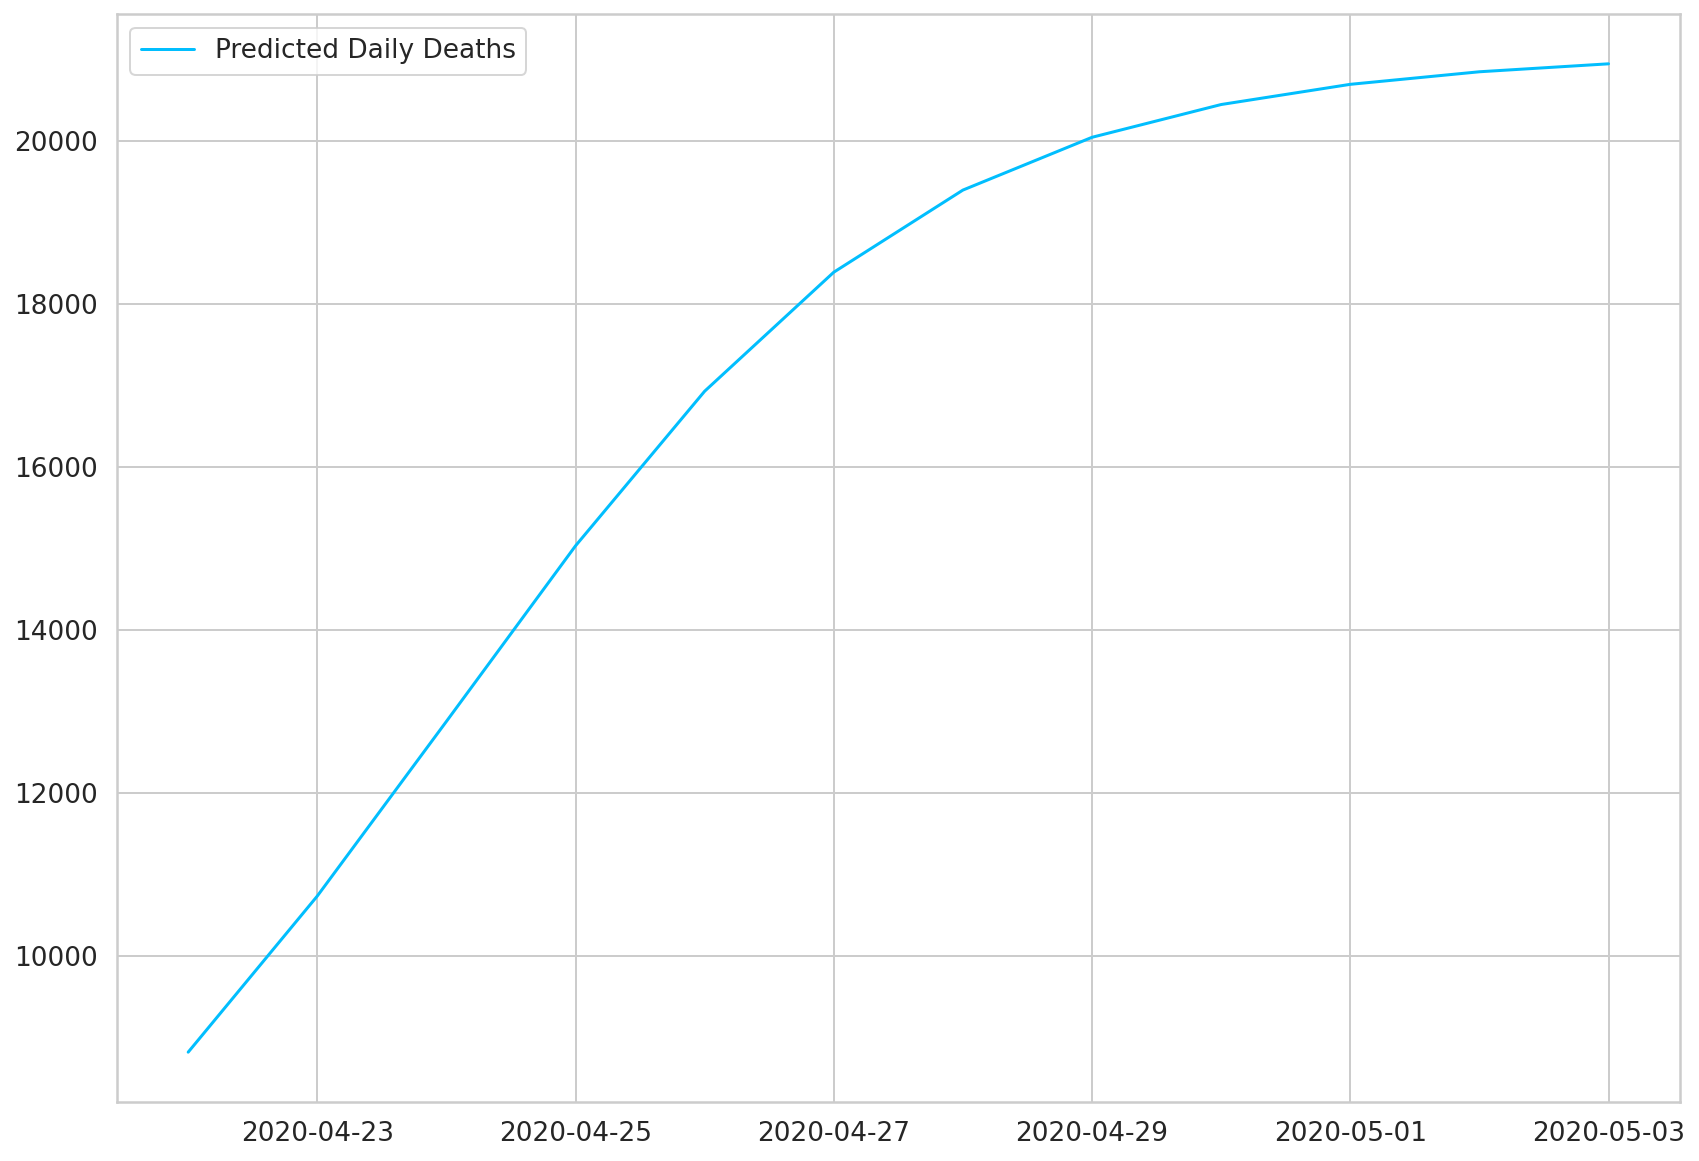

In [66]:
daily_deaths.index[-1]
predicted_index = pd.date_range(
  start=daily_deaths.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Deaths')
plt.legend();

In [67]:
predicted_cases

2020-04-22     8819.808763
2020-04-23    10735.620998
2020-04-24    12878.154539
2020-04-25    15032.797688
2020-04-26    16929.669100
2020-04-27    18389.802662
2020-04-28    19397.385887
2020-04-29    20044.975220
2020-04-30    20447.072040
2020-05-01    20694.863921
2020-05-02    20848.968187
2020-05-03    20946.518742
Freq: D, dtype: float64